In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amprabi_opt_ctrl_state_prep
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.crosstalk_echo_calib
imp

### Set save data

In [4]:
save_data = True

In [5]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240617


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


### Load config

In [71]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

# print(list(im))
# print(im)

In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.267
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=43

In [12]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print(f'set freq to [MHz] {lo_freq*1e-6}')
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

Default Instrument SC_26C1


0

## Set TWPA parameters

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [12]:
"""
TWPA ON
"""

print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN ON
lo_twpa.set_standby(False)
lo_twpa.set_output_state(True)
twpa_freq = float(yaml_cfg.hw.lo.twpa.frequency)
twpa_power = float(yaml_cfg.hw.lo.twpa.power)
lo_twpa.set_frequency(twpa_freq) # Set LO frequency
print(f'set twpa pump freq to {twpa_freq*1e-6} MHz')
lo_twpa.set_power(twpa_power) # Set LO power
print(f'set twpa pump power to {twpa_power} dBm')

Using config file config_q3diamond_full688and638_reset.yml
Default Instrument SC_20A1
set twpa pump freq to 8270.0 MHz
set twpa pump power to 7.5 dBm


In [259]:
"""
TWPA OFF
"""
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN OFF
lo_twpa.set_standby(True)
lo_twpa.set_output_state(False)

Default Instrument SC_20A1


0

# Qubit/resonator to probe

In [22]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [69]:
qubit_i = 3
results_Qi = all_results[qubit_i]

#### Set reps and rounds

In [24]:
reps = 100
rounds = 10

# RFSoC Calibration

In [15]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=0.8, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i]-15, # [MHz]
    reps=reps*rounds, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 7200 + -406.2289384210617


  0%|          | 0/1000 [00:00<?, ?it/s]

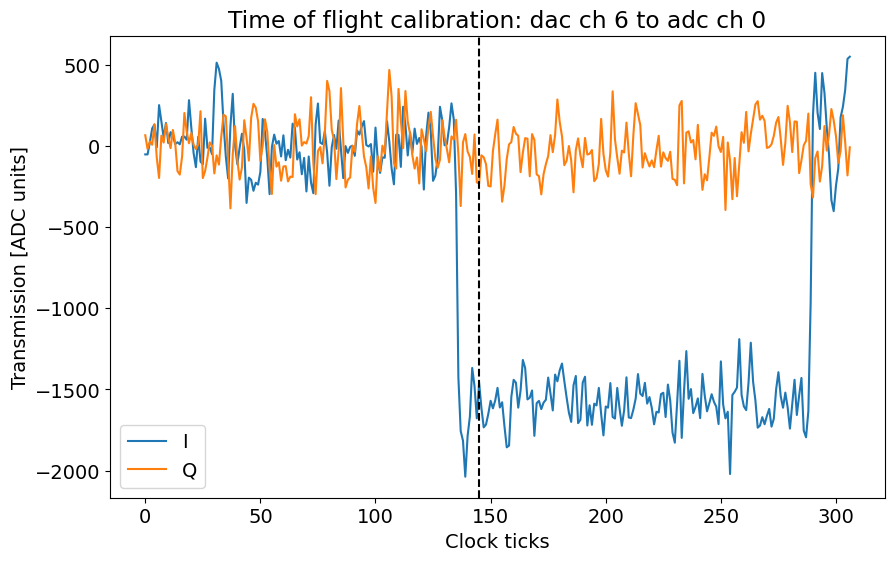

In [16]:
tof.display(adc_trig_offset=145)

# Initial single tone resonator spectroscopy

In [125]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 1.0 # MHz
npts = 250
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain[qubit_i] = 0.2
rspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us] - should be 5x resonator lifetime for good shape

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/250 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) 5.76130804978648
[5794.959333329999, 28974.796666649992, 28974.796666649992, 0, -0.0402426372629203, 0]
Attempted to init fitparam 5 to 0, which is out of bounds 0 to 1.0120592259477146. Instead init to 0.5060296129738573
[5.79489909e+03 5.95735948e+04 6.82759831e+04 3.47224800e-01
 1.17480461e-02 4.00205145e-16]

Freq with minimum transmission: 5794.92533333
Freq with maximum transmission: 5794.46933333
From fit:
	f0: 5794.8990922237535
	Qi: 59573.59476759375 	 kappa_i/2pi: 0.09727294642585518
	Qe: 68275.98314428111 	 kappa_e/2pi: 0.08487463417374667
	Q0: 31814.307240029404
	kappa [MHz]: 0.18214758059960187
	phi [radians]: 0.34722480045337034
baseline 598.0311820259194


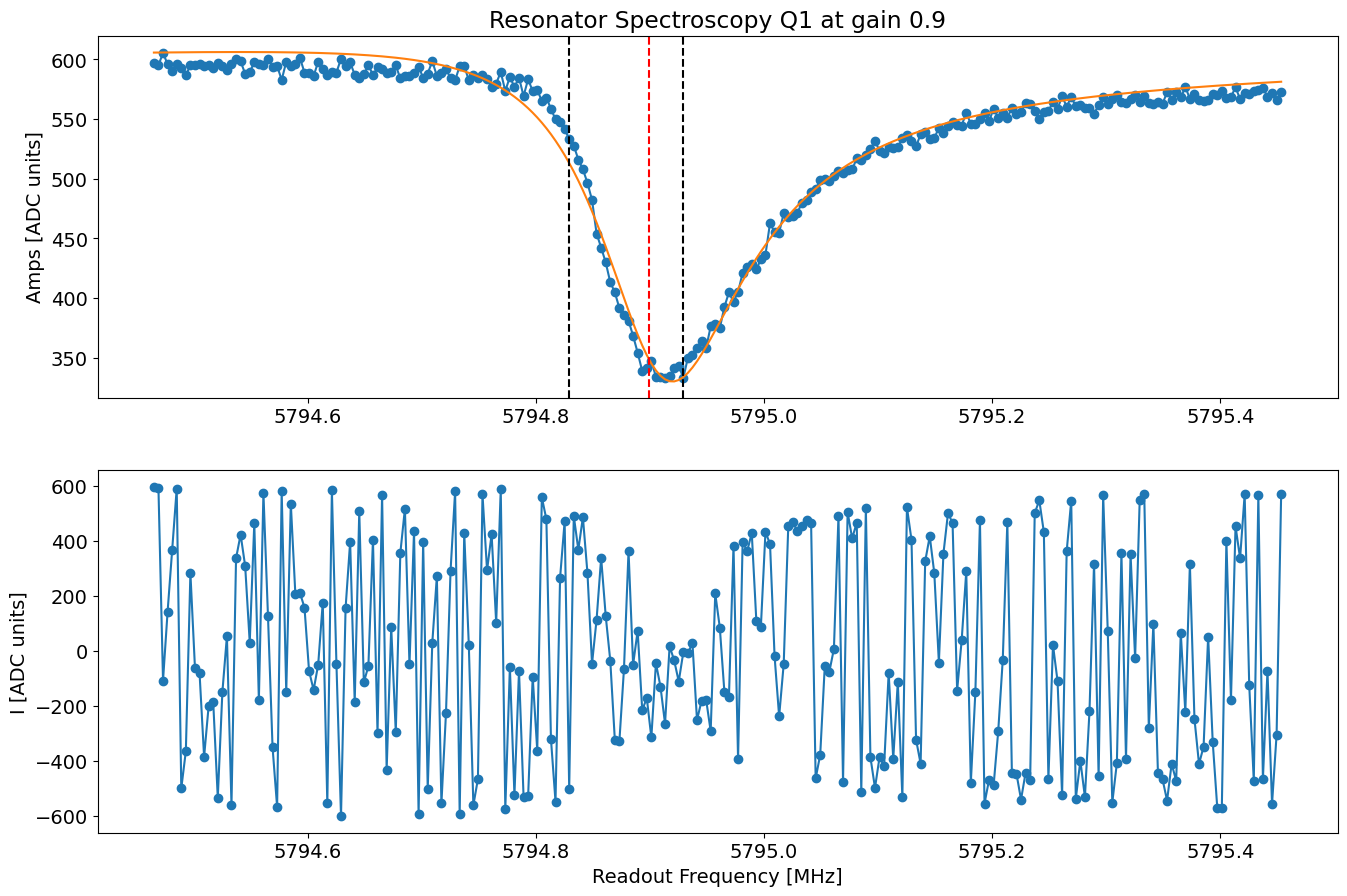

*Set cfg res 1 freq to 5794.92933333*
*Set cfg res 1 gain to 0.9*
qubit 1 {'Single shot g-e fidelity (%)': 62.995000000000005, 'Res freq': 5794.92933333, 'Res kappa': 0.18214758059960187}


In [126]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.data = rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

res_freq_g = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
# res_freq_g = rspec.data['xpts'][np.argmax(rspec.data['amps'])]
yaml_cfg.device.readout.frequency[qubit_i] = res_freq_g

yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain[qubit_i]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq[qubit_i])})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(f'qubit {qubit_i}', results_Qi)

In [113]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00000_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [114]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 300

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4380.294202444435, HWHM 1.0554292531926486
Found peak in I at [MHz] 4380.292749982612, HWHM 1.0659033920818306
Found peak in Q at [MHz] 4380.301735741482, HWHM 1.0861020503090775


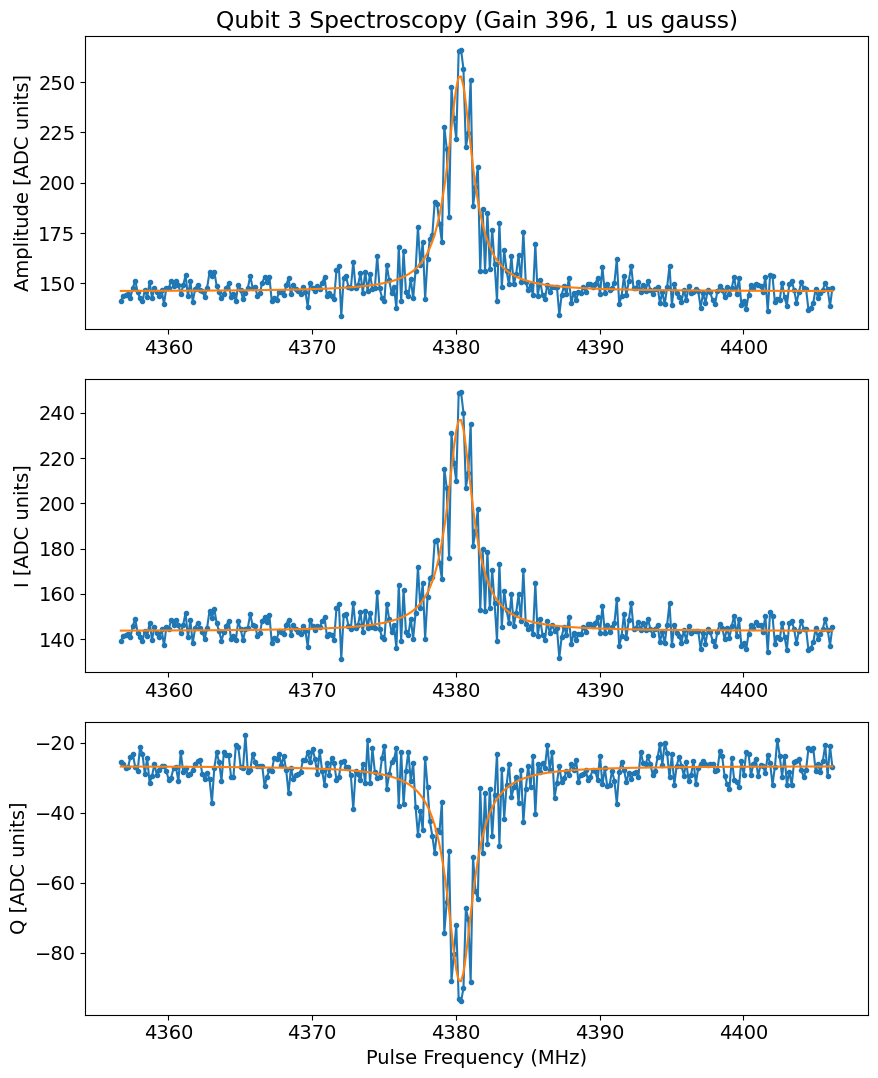

*Set qubit 3 f_ge to 4380.294202444435*
{'Res freq': 6970.1742261, 'Res kappa': 0.20196493605736573, 'Qubit freq': 4380.294202444435}


In [115]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

In [116]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00000_qubit_spectroscopy_qubit3.h5


## Pulse Probe (qubit) spectroscopy round 2

In [21]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 15
npts = 350

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/80), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(results_Qi)

Found peak in amps at [MHz] 4380.512865979809, HWHM 1.0059008008639332
Found peak in I at [MHz] 4380.508869704514, HWHM 1.0097169816909737
Found peak in Q at [MHz] 4380.520866181822, HWHM 1.039194962851501


*Set qubit 3 f_ge to 4380.508869704514*
{'T2R': 30.978000941351098, 'T2R err': 9.096501717407808, 'Qubit freq': 4380.508869704514, 'Pi pulse len': 0.01, 'Pi pulse gain': 4139}


In [119]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00001_qubit_spectroscopy_qubit3.h5


## Length Rabi

In [193]:
# lengthrabi = meas.LengthRabiExperiment(
#     soccfg=soc,
#     path=expt_path,
#     prefix=f"length_rabi_qubit{qubit_i}",
#     config_file=config_path,
# )
# lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

# lengthrabi.cfg.expt = dict(
#     start=0, # pulse length (sigma) [us]
#     step=soc.cycles2us(1), # [us]
#     # step=0.001,
#     expts=121,
#     reps=2000,
#     gain=yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i], # qubit gain [DAC units],
#     # gain=32000, # qubit gain [DAC units],
#     pulse_type='gauss',
#     checkZZ=False,
#     checkEF=False, 
#     qubits=[qubit_i],
# )
# # lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

# import Pyro4.util
# try:
#     lengthrabi.go(analyze=False, display=False, progress=True, save=False)
# except Exception:
#     print("Pyro traceback:")
#     print("".join(Pyro4.util.getPyroTraceback()))

In [354]:
# # # TESTING
# # # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# # temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# # lengthrabi.data = temp_data

# lengthrabi.analyze(fit=True)

# lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

# lengthrabi.display(fit=True)
# p = lengthrabi_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
# else: pi_len = (3/2 - p[2]/180)/2/p[1]
# pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

# lengthrabi_decay = p[3]

# print(f'Will use sigma {pi_len} for amplitude rabi')

In [355]:
# if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude Rabi

In [47]:
pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]
# pi_len = 0.020
print('qubit', qubit_i, 'pi_len', pi_len)

qubit 2 pi_len 0.015


In [48]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i])))
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.00475894103856873
Pi gain from amps data [dac units]: 8607
	Pi/2 gain from amps data [dac units]: 4303
Pi gain from avgi data [dac units]: 8609
	Pi/2 gain from avgi data [dac units]: 4304
Pi gain from avgq data [dac units]: 8601
	Pi/2 gain from avgq data [dac units]: 4300


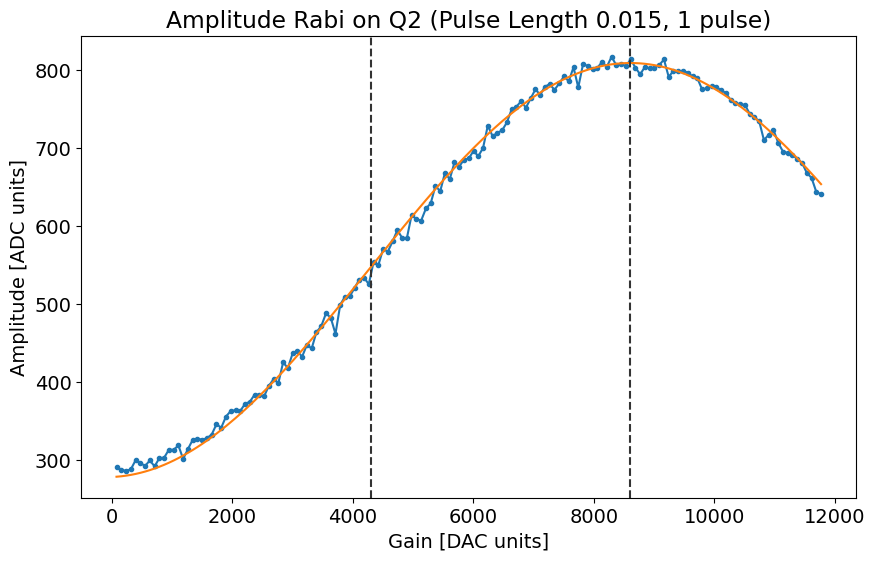

*Set pi pulse sigma for qubit 2 to 0.015*
*Set pi pulse gain for qubit 2 to 8609*
{'T2R': 42.58841611775653, 'T2R err': 4.987599156434765, 'Qubit freq': 4763.932449457171, 'Pi pulse len': 0.015, 'Pi pulse gain': 8609}


In [49]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [268]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00004_amp_rabi_qubit1.h5


## $T_1$

In [223]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [224]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 400
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

best 0 60368.42015670337
Fit T1 amps [us]: 50.96600771737717
Fit T1 avgi [us]: 53.061423592932336
Fit T1 avgq [us]: 53.62870292730022


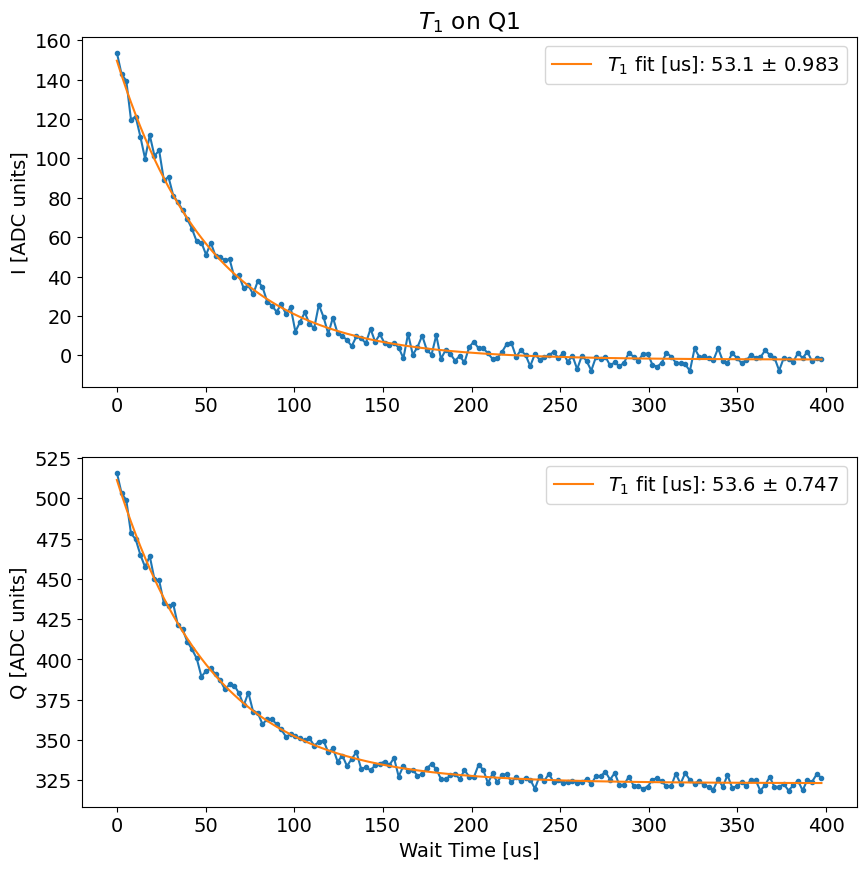

*Set qubit 1 T1 to 51.0*
*Set readout 1 relax delay to 204.0*
qubit 1 {'Single shot g-e fidelity (%)': 85.9364452333925, 'Res freq': 5794.92933333, 'Res kappa': 0.18214758059960187, 'T2R': 15.590122767857144, 'T2R err': 4.145965326441711, 'Qubit freq': 3452.6911369440354, 'Pi pulse len': 0.025, 'Pi pulse gain': 1955, 'T1': 50.96600771737717, 'T1 err': 0.6969887815280343}


In [225]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit_log=False)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True, fit_log=False)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(4*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(f'qubit {qubit_i}', results_Qi)

In [226]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00001_t1_qubit1.h5


## $T_2$ Ramsey round 1

In [36]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [37]:
# ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
ramsey_freq = 3.0
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 3.0


In [38]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(1) if short_T1 else soc.cycles2us(8), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=200,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=reps,
    rounds=rounds,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.022080120956396776
Current pi pulse frequency: 4763.815758924647
Fit frequency from amps [MHz]: 2.883750387358085 +/- 0.0009442500627910501
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4763.932008537288
 	4757.932008537288
T2 Ramsey from fit amps [us]: 16.052508327419968 +/- 1.4728987027660057
Current pi pulse frequency: 4763.815758924647
Fit frequency from I [MHz]: 2.8836901319023265 +/- 0.0009365436296576932
Suggested new pi pulse frequency from fit I [MHz]:
 	4763.932068792744
 	4757.932068792744
T2 Ramsey from fit I [us]: 15.623815165423364 +/- 1.3839386656944672
Fit frequency from Q [MHz]: 2.8817159105849535 +/- 0.0016660620671075472
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4763.934043014062
 	4757.934043014062
T2 Ramsey from fit Q [us]: 15.562291714675256 +/- 2.4449431861314057


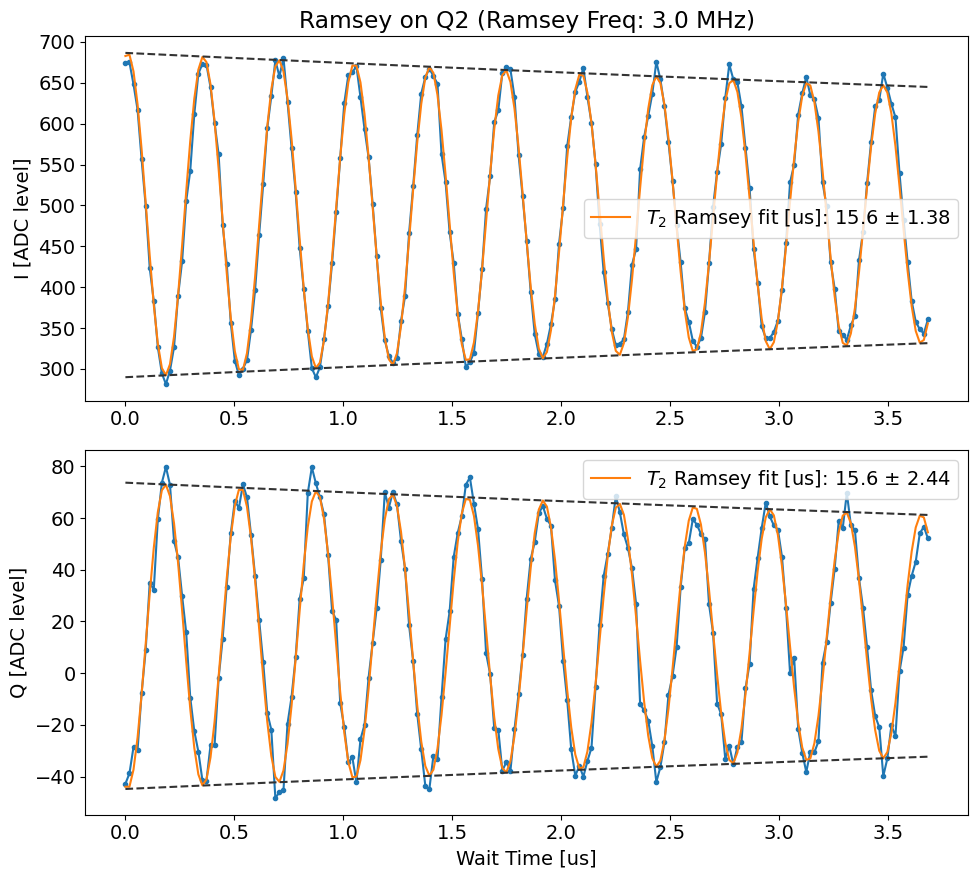

*Set qubit 2 freq to 4763.932068792744*
Alt qubit freq is 4757.932068792744


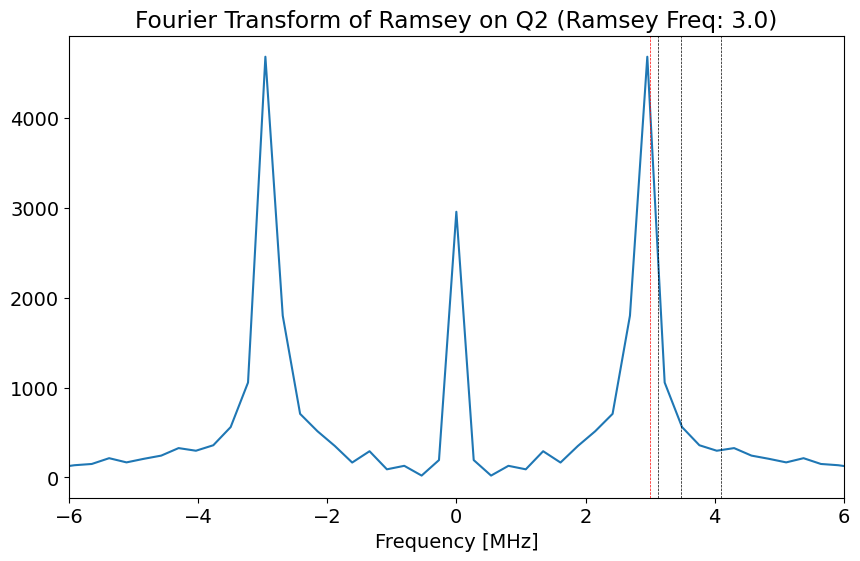

In [39]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

# t2r.analyze(fit=False, fit_num_sin=2)
# t2r.display(fit=False, fit_num_sin=2)

t2r.analyze(fit=True)
t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge[qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
results_Qi.update({'T2R':t2r_fit[3], 'T2R err':np.sqrt(t2r_fit_err[3][3])})
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

data = t2r.data
fit_axis = 'avgq'
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data[fit_axis])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
ZZs = np.reshape(t2r.cfg.device.qubit.ZZs, (4, 4))
for i in range(4):
    if (qubit_i+i)%4 == qubit_i: color = 'r'
    else: color = 'k'
    plt.axvline(t2r.cfg.expt.ramsey_freq - ZZs[qubit_i, (qubit_i+i)%4], color=color, linewidth=0.5, linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey on Q{qubit_i} (Ramsey Freq: {t2r.cfg.expt.ramsey_freq})')
plt.show()



In [231]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00006_ramsey_qubit1.h5


## Amplitude Rabi round 2

In [40]:
pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]
print('qubit', qubit_i, 'pi_len', pi_len)
# pi_len = 0.010

qubit 2 pi_len 0.008


In [41]:
amprabi_2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_2.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/n_pulses))))
npts = 151
    
amprabi_2.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    n_pulses=n_pulses,
    qubits=[qubit_i],
)
amprabi_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.004103813075841487
Pi gain from amps data [dac units]: 17266
	Pi/2 gain from amps data [dac units]: 8633
Pi gain from avgi data [dac units]: 17271
	Pi/2 gain from avgi data [dac units]: 8635
Pi gain from avgq data [dac units]: 17307
	Pi/2 gain from avgq data [dac units]: 8653


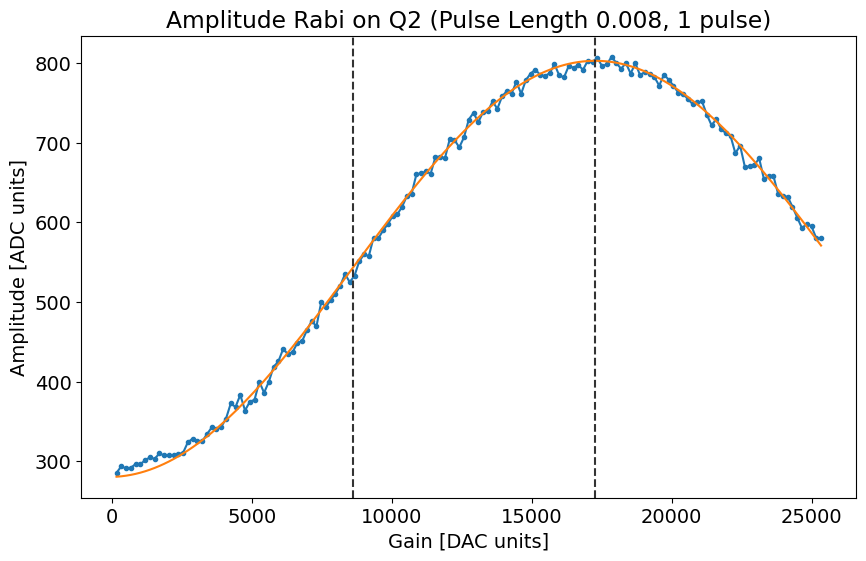

*Set pi pulse sigma for qubit 2 to 0.008*
*Set pi pulse gain for qubit 2 to 17266*
{'T2R': 15.623815165423364, 'T2R err': 1.3839386656944672, 'Qubit freq': 4763.932068792744, 'Pi pulse len': 0.008, 'Pi pulse gain': 17266}


In [42]:
# # TESTING
# # amprabi_2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_2.data = temp_data

amprabi_2.analyze(fit=True)

amprabi_2_fit, amprabi_2_fit_err = meas.fitting.get_best_fit(amprabi_2.data)

p = amprabi_2_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_2.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_2.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi_2.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(n_pulses*pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_2.save_data())

## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [43]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(2) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    # step=soc.cycles2us(30), # [us]
    # step=soc.cycles2us(40), # [us]
    # step=soc.cycles2us(80), # [us]
    step=soc.cycles2us(150), # [us]
    expts=151,
    # ramsey_freq=ramsey_freq/3, # [MHz]
    ramsey_freq=ramsey_freq/15, # [MHz]
    # ramsey_freq=ramsey_freq/20, # [MHz]
    reps=reps,
    rounds=rounds,
    checkZZ=False,
    checkEF=False,
    qubits=[qubit_i],
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.04467828695210999
Current pi pulse frequency: 4763.932068792744
Fit frequency from amps [MHz]: 0.19963280074226455 +/- 0.00043582568619619864
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4763.932435992002
 	4763.532435992001
T2 Ramsey from fit amps [us]: 43.61894239257438 +/- 5.153853095022743
Current pi pulse frequency: 4763.932068792744
Fit frequency from I [MHz]: 0.1996193355723641 +/- 0.0004425854359908224
Suggested new pi pulse frequency from fit I [MHz]:
 	4763.932449457171
 	4763.532449457171
T2 Ramsey from fit I [us]: 42.58841611775653 +/- 4.987599156434765
Fit frequency from Q [MHz]: 0.199609804073138 +/- 0.0004762021088690921
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4763.932458988671
 	4763.53245898867
T2 Ramsey from fit Q [us]: 46.19304330075401 +/- 6.323310554498705


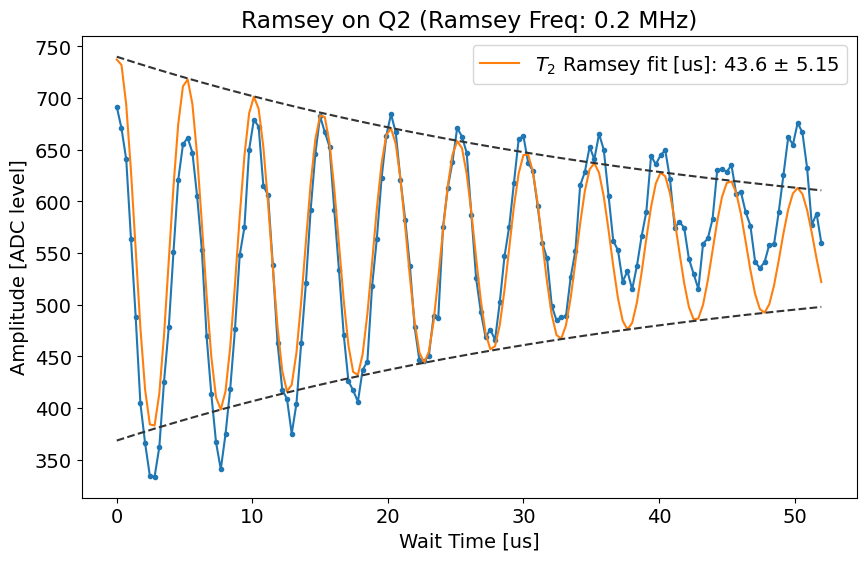

*Set qubit 2 freq to 4763.932449457171*
{'T2R': 42.58841611775653, 'T2R err': 4.987599156434765, 'Qubit freq': 4763.932449457171, 'Pi pulse len': 0.008, 'Pi pulse gain': 17266}
Redo T2R: False


In [44]:
# TESTING
# t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00004_ramsey_qubit2.h5')
# t2r_2.data = temp_data
# t2r_2.cfg = AttrDict(attrs['config'])

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge[qubit_i] + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= ramsey_freq/10:
# if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [238]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00007_ramsey_qubit1.h5


## GE error amplification

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.1689384211, 5794.82533333, 501.1779, -230.0617739], 'gain': [0.45, 0.4, 0.9, 0.53], 'readout_length': [7.0, 8.0, 8.0, 9.0], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4112.28209738023, 3449.830881015124, 4763.4773016263525, 4382.5319372213835], 'f_ef': [3886.1983246274285, 3349.5687103285777, 4574.541447227951, 4209.792630242738], 'f_Q1_ZZ': [3443.976854588233, 0, 3448.196531981392, 3448.0020087133726], 'f_Q_ZZ1': [4107.855190582331, 0, 4763.454886038179, 4381.229185344628], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5886.566666666667, 5147.15], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653352423196, 2.6415018214608046, 6.386231497692186], 'ZZs': [0.0, -5.329406851725253, -0.14402660427003866, -0.5677241157300159, -5.315166814608347, 0.0, -1.0954894214492015, -1.2900126894687673, -0.1500150

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (2)


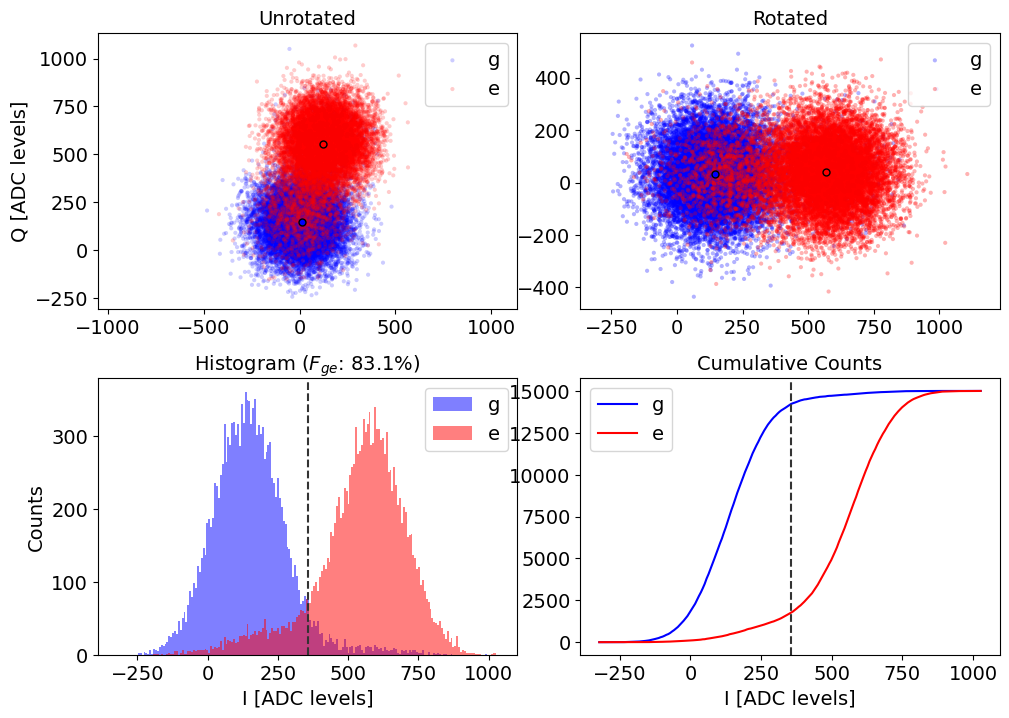

ge fidelity (%): 83.08276942564751 	 angle (deg): -73.08836772350499 	 threshold ge: 355.68024995585984
thresholds=[0, 0, 355.68024995585984, 0],
angles=[0, 0, -73.08836772350499, 0],
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [11.660584947111474, 154.8144265527529, 120.94858934092757, 533.5926630322756], array([0., 0., 0., 0.])],
counts_calib=[[14139, 3, 858, 0], [1692, 0, 13308, 0]]


  0%|          | 0/20 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py:325: RuntimeWarning: divide by zero encountered in divide
  avgi_rot /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]
s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py:326: RuntimeWarning: divide by zero encountered in divide
  avgi_err /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]


In [285]:
npulsecalib = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    test_pi_half=False,

    post_process='scale',
    singleshot_reps=15000,
)

print(npulsecalib.cfg)
import Pyro4.util
try:
    npulsecalib.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

From amps: adjust amplitude to (current gain) / 0.9999920726224452


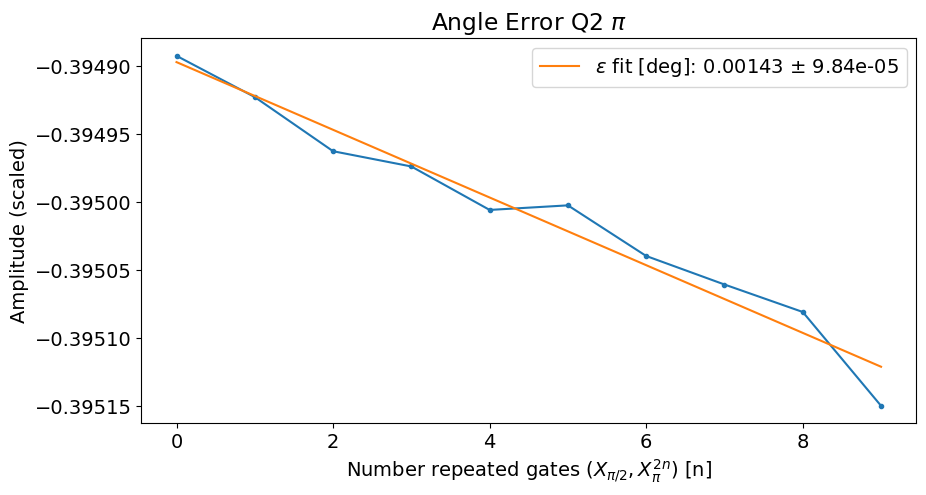

From avgi: adjust amplitude to (current gain) / 0.9999715484989041

From avgq: adjust amplitude to (current gain) / 0.9999999485425036


0
*Set pi pulse gain for qubit 2 to 13056*
{'Res freq': 7701.1699, 'Res kappa': 0.2619607399901572, 'Qubit freq': 4763.4773016263525, 'Pi pulse len': 0.01, 'Pi pulse gain': 13056, 'T1': 56.5602087243591, 'T1 err': 2.5871656126770692, 'T2R': 16.825743234633755, 'T2R err': 1.6316966287022652, 'T2E': 53.88755059920002, 'T2E err': 3.5153908616136174, 'Qubit EF freq': 4574.541447227951, 'EF pi pulse len': 0.008, 'EF pi pulse gain': 12578, 'Qubit temp [mK]': 74.46797388048053, 'Single shot g-e fidelity (%)': 83.39999999999999}


In [286]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True, scale=data['ge_avgs'])
npulsecalib.display(fit=True, scale=data['ge_avgs'])

npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)

angle_err = npulsecalib_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ge = npulsecalib.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(round(new_amp_ge))
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(results_Qi)

In [390]:
if save_data: npulsecalib.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240508\00000_NPulseExptQ3.h5


## $T_2$ Echo

In [152]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
# short_T1 = True
# short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [153]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 2.0


In [154]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    # step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    step=soc.cycles2us(30) if short_T1 else soc.cycles2us(150), # [us] 
    expts=201,
    ramsey_freq=max((ramsey_freq/15, 0.100)), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=reps,
    # reps=10,
    rounds=rounds,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Qubit 1
Current qubit frequency: 3452.659891436045
Fit frequency from I [MHz]: 0.13366532997385858 +/- 0.00031120621098251896
T2 Echo from fit I [us]: 47.74484522134261
Fit frequency from Q [MHz]: 0.13350696694093706 +/- 0.0001243806865174456
T2 Echo from fit Q [us]: 48.06751591836087


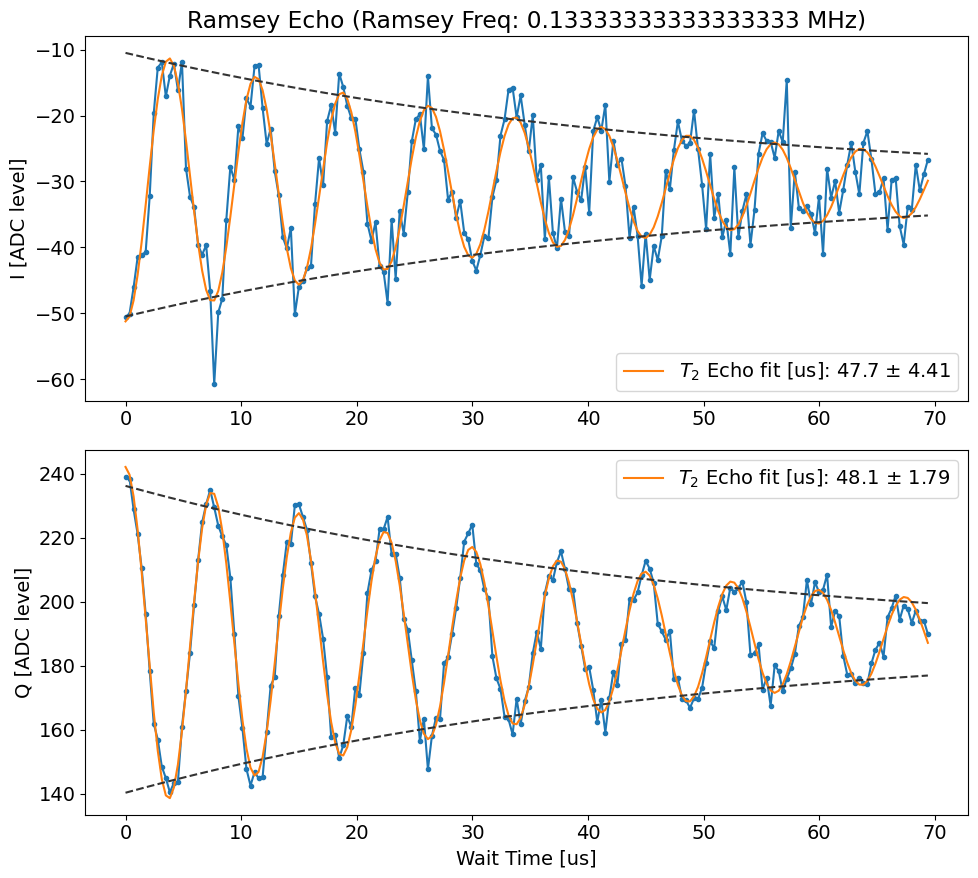

{'Res freq': 5794.96133333, 'Res kappa': 0.17476501522800506, 'Qubit freq': 3452.659891436045, 'Pi pulse len': 0.025, 'Pi pulse gain': 1975, 'T1': 68.13793141400109, 'T1 err': 2.353281049187661, 'T2R': 15.590122767857144, 'T2R err': 1.2838754950325688, 'T2E': 48.031951660632146, 'T2E err': 1.6951907363667957}


In [155]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

print(f'Qubit {qubit_i}')
t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(results_Qi)
# print('Results updated.')

In [325]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240610\00000_echo_qubit3.h5


# Resonator chi shift (g/e)

In [312]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 3 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) -0.6737751626389084
[6970.164292325166, 34850.82146162583, 34850.82146162583, 0, -0.0032041368399890868, 0]
Attempted to init fitparam 5 to 0, which is out of bounds 0 to 1.0096093124523922. Instead init to 0.5048046562261961
[ 6.97020746e+03  3.63553702e+04  7.38611284e+04 -9.08380278e-02
  4.80620526e-03  3.97628349e-40]

Freq with minimum transmission: -229.85557522450333
Freq with maximum transmission: -231.166833502649
From fit:
	f0: 6970.207464825517
	Qi: 36355.37021953966 	 kappa_i/2pi: 0.1917242878489321
	Qe: 73861.1284330431 	 kappa_e/2pi: 0.09436908984059428
	Q0: 24363.400233575867
	kappa [MHz]: 0.2860933776895264
	phi [radians]: -0.09083802780819412
baseline 417.1289200873533


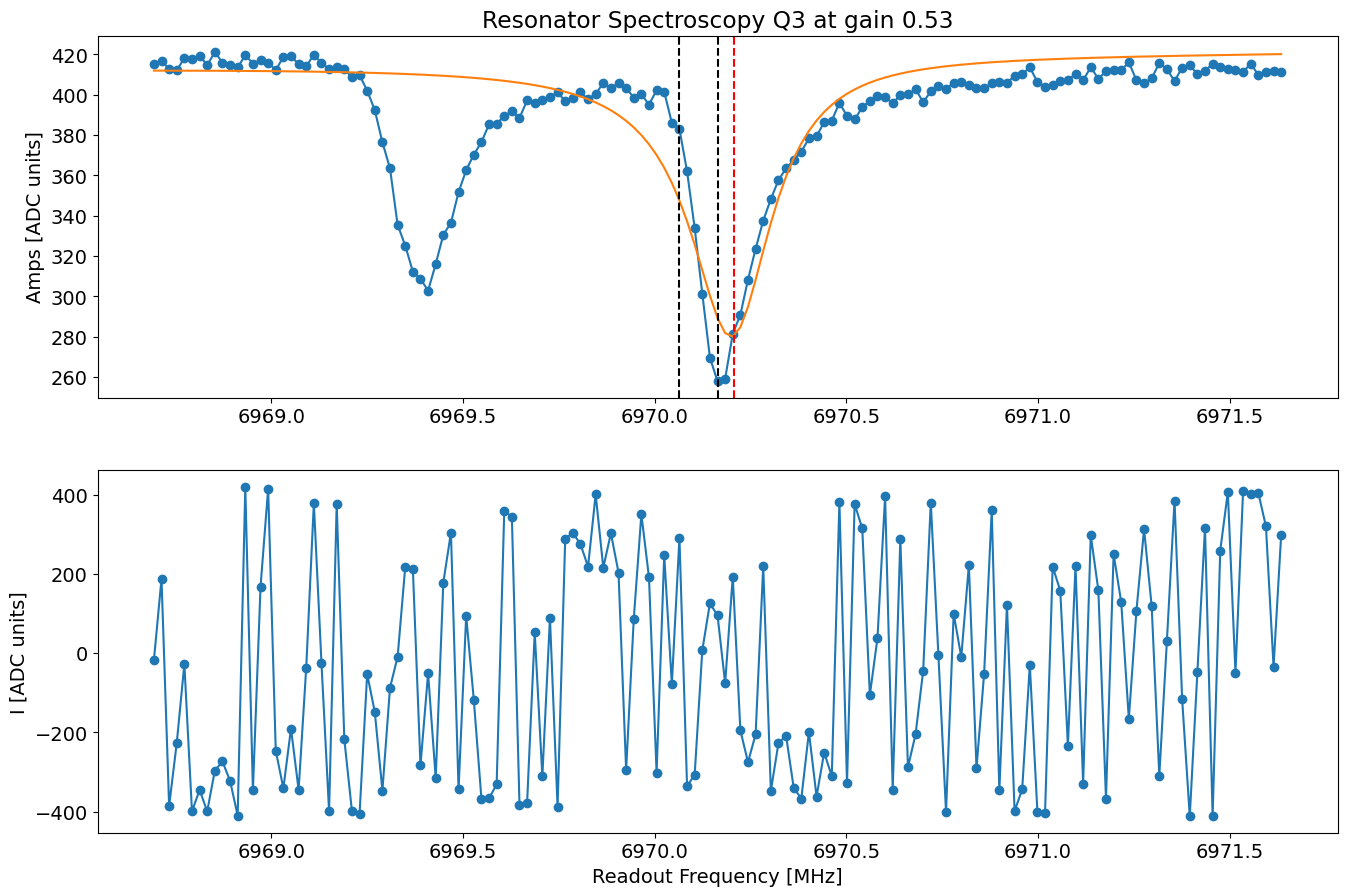

Res freq e -229.83570767483445
Res freq g -229.8257739
Chi shift (e-g): -0.009933774834451015
qubit 3 {'Res freq': 6970.1782261, 'Res kappa': 0.2073967222734667, 'Qubit freq': 4380.358818917405, 'Pi pulse len': 0.02, 'Pi pulse gain': 1966, 'T1': 77.9872720859363, 'T1 err': 1.457265739546417, 'T2R': 42.063296532225905, 'T2R err': 1.4282231321574412, 'Qubit EF freq': 4204.925869939066, 'EF pi pulse len': 0.008, 'EF pi pulse gain': 8302, 'Qubit temp [mK]': 112.05996907704251, 'Qubit E thermal population (%)': 18.091957483371555, 'T2R EF': 1.039341517857143, 'T2R EF err': 0.5999630417912378, 'Res chi shift (e - g)': -0.009933774834451015}


In [313]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.data = rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = rspec_chi.data['xpts'][np.argmax(rspec_chi.data['amps'])]
print('Res freq e', res_freq_e)
res_freq_g = yaml_cfg.device.readout.frequency[qubit_i]
print('Res freq g', res_freq_g)
# res_freq_e = -83
# results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
chi_shift_eg = yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - res_freq_g)
print('Chi shift (e-g):', chi_shift_eg)
results_Qi.update({'Res chi shift (e - g)': chi_shift_eg})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(f'qubit {qubit_i}', results_Qi)

In [328]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240610\00000_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [66]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/50), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qubit=qubit_i,
)
# qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/15 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4207.921984006256, HWHM 1.9928988391100086
Found peak in I at [MHz] 4207.93120275023, HWHM 2.022516008444013
Found peak in Q at [MHz] 4207.870430567762, HWHM 2.096092145296575


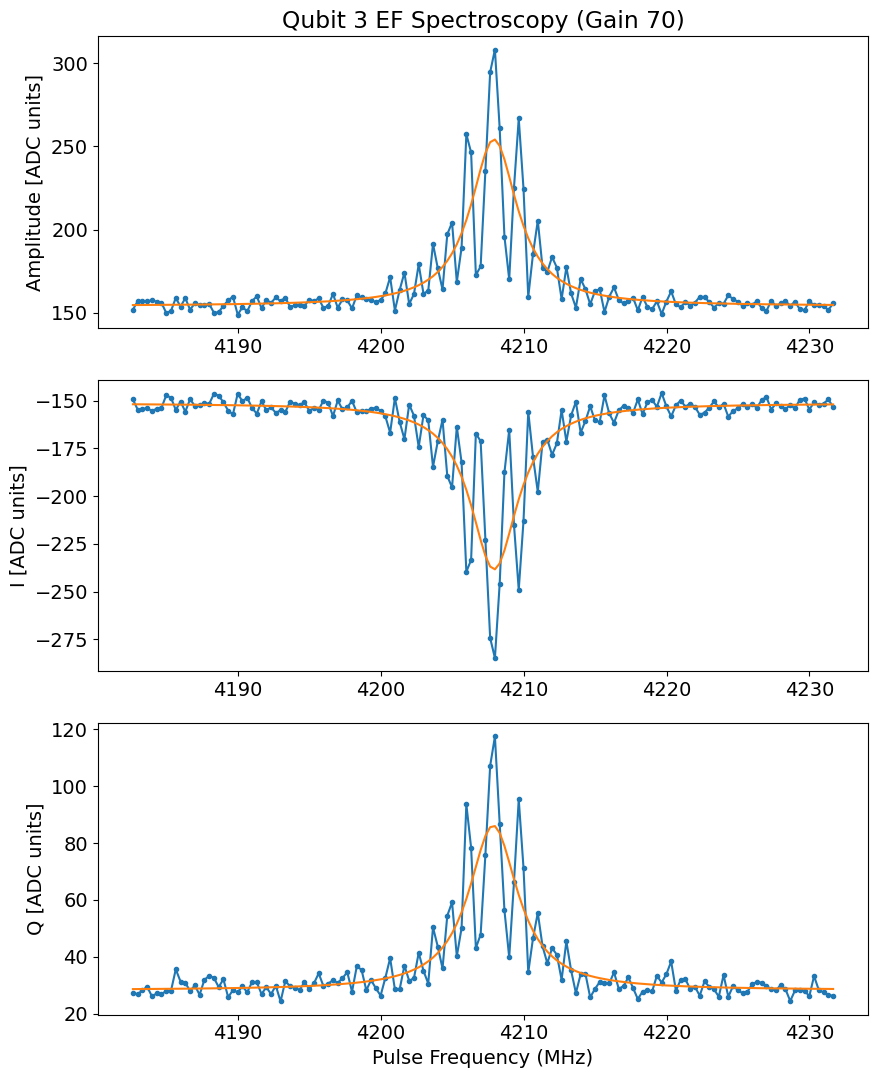

*Set qubit 3 f_ef to 4207.870430567762*
[{}, {}, {}, {'T2R': 45.05585862624684, 'T2R err': 1.692388940682623, 'Qubit freq': 4380.611423383357, 'Pi pulse len': 0.01, 'Pi pulse gain': 3936, 'T1': 48.26692080291215, 'T1 err': 0.9029257400818065, 'Single shot g-e fidelity (%)': 71.26534490086756, 'Qubit EF freq': 4207.870430567762}]


In [67]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [68]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00002_qubit_EF_spectroscopy_qubit3.h5


## Pulse Probe EF spectroscopy round 2

In [69]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/80), # ef pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4207.8957220776465, HWHM 1.6936548281389259
Found peak in I at [MHz] 4207.889744087148, HWHM -1.7139706828704209
Found peak in Q at [MHz] 4207.91624049985, HWHM 1.663436193201902


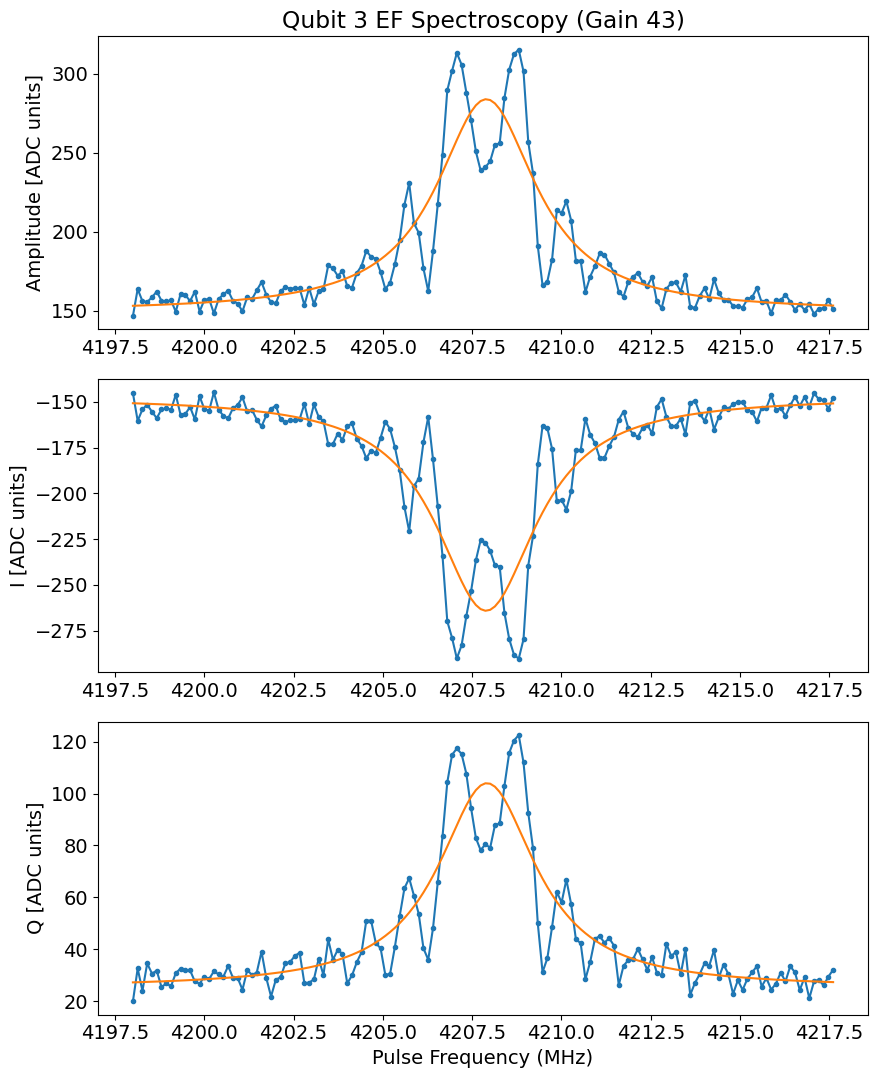

*Set qubit 3 f_ef to 4207.889744087148*
[{}, {}, {}, {'T2R': 45.05585862624684, 'T2R err': 1.692388940682623, 'Qubit freq': 4380.611423383357, 'Pi pulse len': 0.01, 'Pi pulse gain': 3936, 'T1': 48.26692080291215, 'T1 err': 0.9029257400818065, 'Single shot g-e fidelity (%)': 71.26534490086756, 'Qubit EF freq': 4207.889744087148}]


In [70]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [71]:
if save_data: saved_files.append(qEFspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00003_qubit_EF_spectroscopy_qubit3.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [72]:
pi_lenEF = yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]
# pi_lenEF = 0.020
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 3 pi_lenEF 0.01


In [73]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    rounds=rounds,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.007019221013118541
Pi gain from amps data [dac units]: 2709
	Pi/2 gain from amps data [dac units]: 1354
Pi gain from avgi data [dac units]: 2707
	Pi/2 gain from avgi data [dac units]: 1353
Pi gain from avgq data [dac units]: 2722
	Pi/2 gain from avgq data [dac units]: 1361


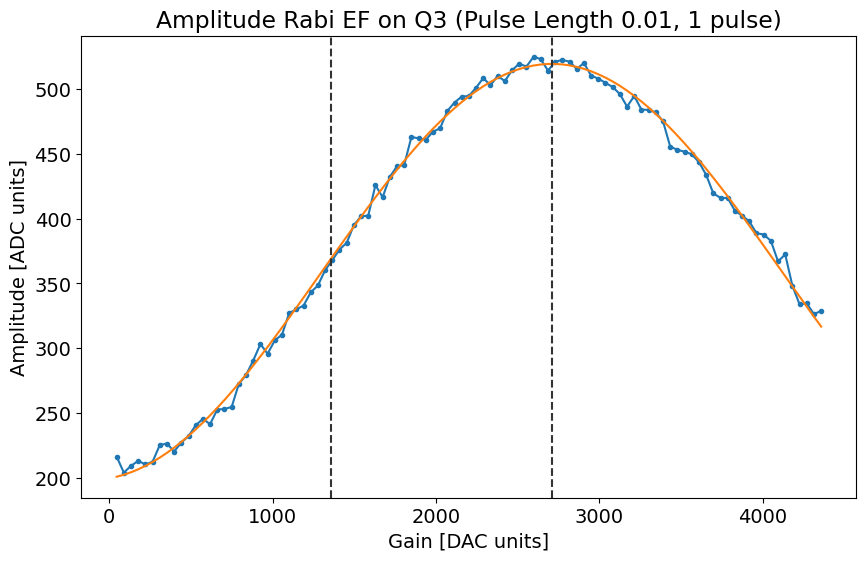

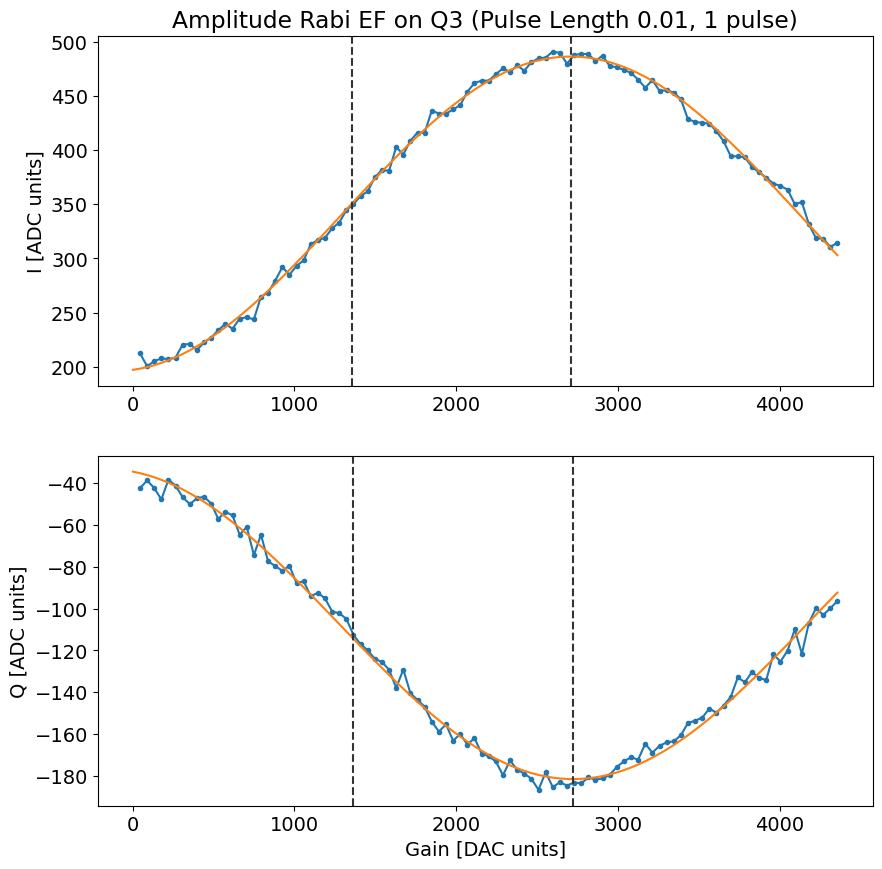

*Set EF pi pulse sigma for qubit 3 to 0.01*
*Set EF pi pulse gain for qubit 3 to 2709*
qubit 3 {'EF pi pulse len': 0.01, 'EF pi pulse gain': 2709}


In [74]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(f'qubit {qubit_i}', all_results[qubit_i])

In [75]:
if save_data: saved_files.append(amprabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00003_amp_rabi_EF_qubit3.h5


## Length EF Rabi

In [84]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(3), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=reps*rounds,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

0
Pi length from avgi data [us]: 0.05999948940055126
	Pi/2 length from avgi data [us]: 0.02999974470027563

Pi length from avgq data [us]: 0.05981355555072877
Pi/2 length from avgq data [us]: 0.029906777775364386


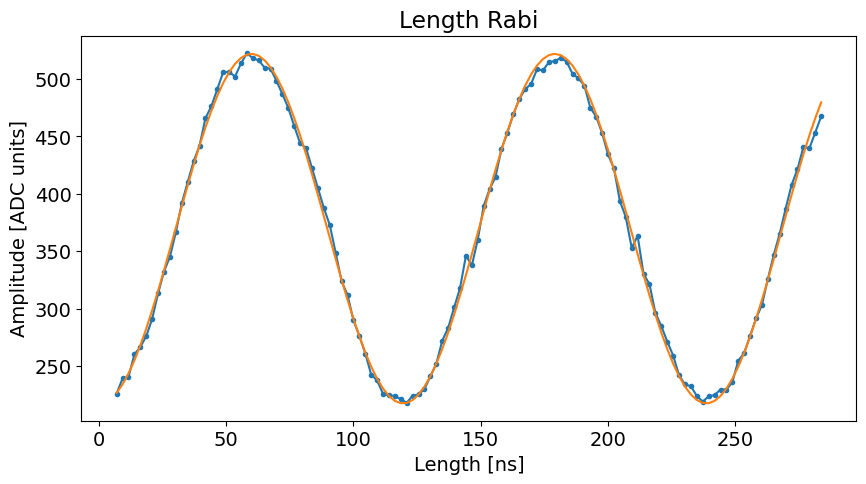

In [85]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True, fit_func='sin')

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True, fit_func='sin')
p = lengthrabiEF_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
# else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
# pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

# lengthrabiEF_decay = p[3]

# print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [86]:
if save_data: saved_files.append(lengthrabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240508\00000_length_rabiEF_qubit0.h5


## Qubit temperature

In [260]:
amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF2.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, 1.25*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
npts = 101

amprabiEF2.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    rounds=rounds*10,
    sigma_test=pi_lenEF*3, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    qubits=[qubit_i],
)

# print(amprabiEF2.cfg)
amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/100 [00:00<?, ?it/s]

best 0 0.012362747801770515
Pi gain from amps data [dac units]: 407
	Pi/2 gain from amps data [dac units]: 203
Pi gain from avgi data [dac units]: 407
	Pi/2 gain from avgi data [dac units]: 203
Pi gain from avgq data [dac units]: 401
	Pi/2 gain from avgq data [dac units]: 200


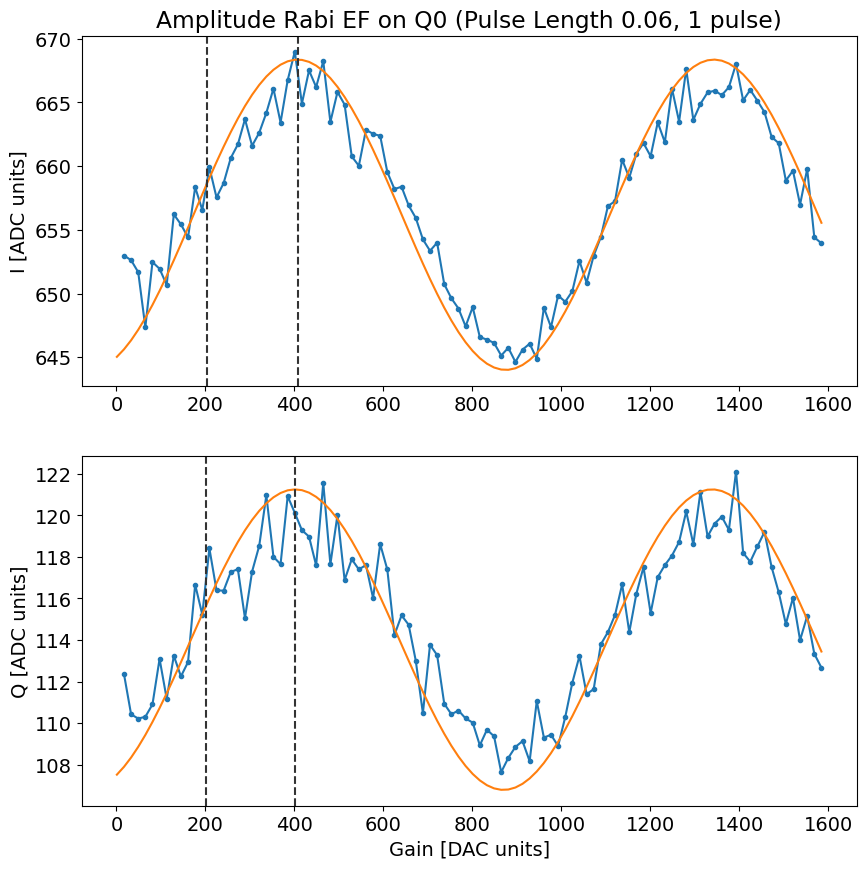

yscale normal: 384.6819795483676
yscale no pulse: 12.964844935102407
Qubit temp [mK]: 57.60817537940262
Qubit E thermal population (%): 3.370276130512707
qubit 0
{'Single shot g-e fidelity (%)': 78.33891694584729, 'EF pi pulse len': 0.02, 'EF pi pulse gain': 1341, 'Qubit EF freq': 3883.353845445429, 'T2R EF': 4.047864483420217, 'T2R EF err': 0.2067796580690182, 'Qubit temp [mK]': 57.60817537940262, 'Qubit E thermal population (%)': 3.370276130512707}


In [261]:
# TESTING
# amprabiEF_test = meas.AmplitudeRabiExperiment(config_file=config_path,)
# amprabiEF2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00004_amp_rabi_EF_qubit1.h5')
# amprabiEF2.data = temp_data

# amprabiEF2.analyze(fit=False)
# amprabiEF2.display(fit=False)

fitparams = [None]*4
fitparams[1] = 2/amprabiEF2.data['xpts'][-1]
amprabiEF2.analyze(fit=True, fitparams=fitparams)

amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF2.cfg.device.qubit.f_ge[qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

fit_axis = 'amps'
# fit_axis = 'avgq'

amprabiEF_data = amprabiEF.data[fit_axis]
# amprabiEF2_data = (amprabiEF2.data[fit_axis] + temp_data[fit_axis])/2
p = amprabiEF.data[f'fit_{fit_axis}']
# efamp_normal = p[0]
efamp_normal = max(amprabiEF.data[fit_axis]) - min(amprabiEF.data[fit_axis])

amprabiEF2_data = amprabiEF2.data[fit_axis]
p = amprabiEF2.data[f'fit_{fit_axis}']
efamp_nopulse = p[0]
# fit_vals = meas.fitting.sinfunc(amprabiEF.data['xpts'], *p)
# std_dev_no_pulse = np.std(fit_vals[:10])
# efamp_nopulse = (max(fit_vals) - min(fit_vals))-2*std_dev_no_pulse

amprabiEF2.display(fit=True, fit_func='sin')


print('yscale normal:', efamp_normal)
print('yscale no pulse:', efamp_nopulse)

temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))

print('Qubit temp [mK]:', temp)
results_Qi.update({'Qubit temp [mK]':temp})
print('Qubit E thermal population (%):', efamp_nopulse/efamp_normal*100)
results_Qi.update({'Qubit E thermal population (%)':efamp_nopulse/efamp_normal*100})
print(f'qubit {qubit_i}')
print(results_Qi)

In [262]:
(1-0.0337)*0.03

0.028989

In [248]:
if save_data: saved_files.append(amprabiEF2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00007_amp_rabi_EF_qubit1.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [63]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubitEF_hwhm = 2
# short_T1 = False

In [64]:
ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=reps,
    rounds=rounds,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.024806802789383228
Current pi pulse frequency: 3318.804358953224
Fit frequency from amps [MHz]: 2.165873215431707 +/- 0.006272471131547222
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3318.638485737792
 	3314.638485737792
T2 Ramsey from fit amps [us]: 1.4843867582745391 +/- 0.08344309151009062
Current pi pulse frequency: 3318.804358953224
Fit frequency from I [MHz]: 2.1653318780779545 +/- 0.006620852366380107
Suggested new pi pulse frequency from fit I [MHz]:
 	3318.639027075146
 	3314.639027075146
T2 Ramsey from fit I [us]: 1.4633197638334248 +/- 0.08561691624916268
Fit frequency from Q [MHz]: 2.166368799690771 +/- 0.006315028467843072
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3318.6379901535333
 	3314.6379901535333
T2 Ramsey from fit Q [us]: 1.5056538081933486 +/- 0.08641459079947425


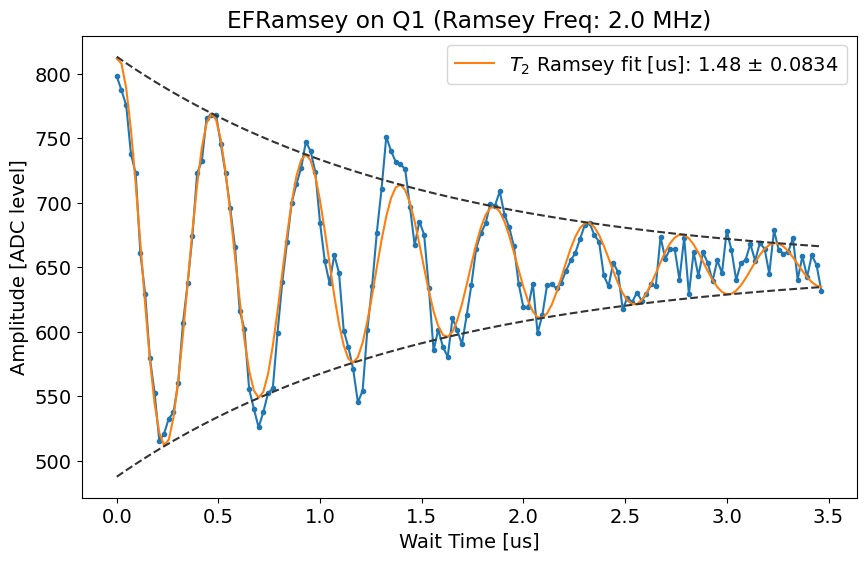

*Set qubit 1 EF freq to 3318.638485737792*
[{'T2R': 48.17842249635457, 'T2R err': 1.5564438343919038, 'Qubit freq': 4109.191979657045, 'Pi pulse len': 0.02, 'Pi pulse gain': 1958}, {'EF pi pulse len': 0.025, 'EF pi pulse gain': 2289, 'Qubit EF freq': 3318.638485737792, 'T2R EF': 1.4843867582745391, 'T2R EF err': 0.08344309151009062}, {'T2R': 42.58841611775653, 'T2R err': 4.987599156434765, 'Qubit freq': 4763.932449457171, 'Pi pulse len': 0.015, 'Pi pulse gain': 8609, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 6303, 'Qubit EF freq': 4576.568833764635, 'T2R EF': 11.928737962468755, 'T2R EF err': 1.1005834024982384}, {}]


In [65]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
results_Qi.update({'T2R EF':t2EFr_fit[3], 'T2R EF err':np.sqrt(t2EFr_fit_err[3][3])})
print(all_results)

In [242]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00002_ramseyEF_qubit1.h5


## Amplitude EF Rabi round 2

In [66]:
pi_lenEF = yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]
# pi_lenEF = 0.020
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 1 pi_lenEF 0.025


In [67]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/n_pulses))))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    rounds=rounds,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    n_pulses=n_pulses,
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.007925187471412848
Pi gain from amps data [dac units]: 2203
	Pi/2 gain from amps data [dac units]: 1101
Pi gain from avgi data [dac units]: 2192
	Pi/2 gain from avgi data [dac units]: 1096
Pi gain from avgq data [dac units]: 2212
	Pi/2 gain from avgq data [dac units]: 1106


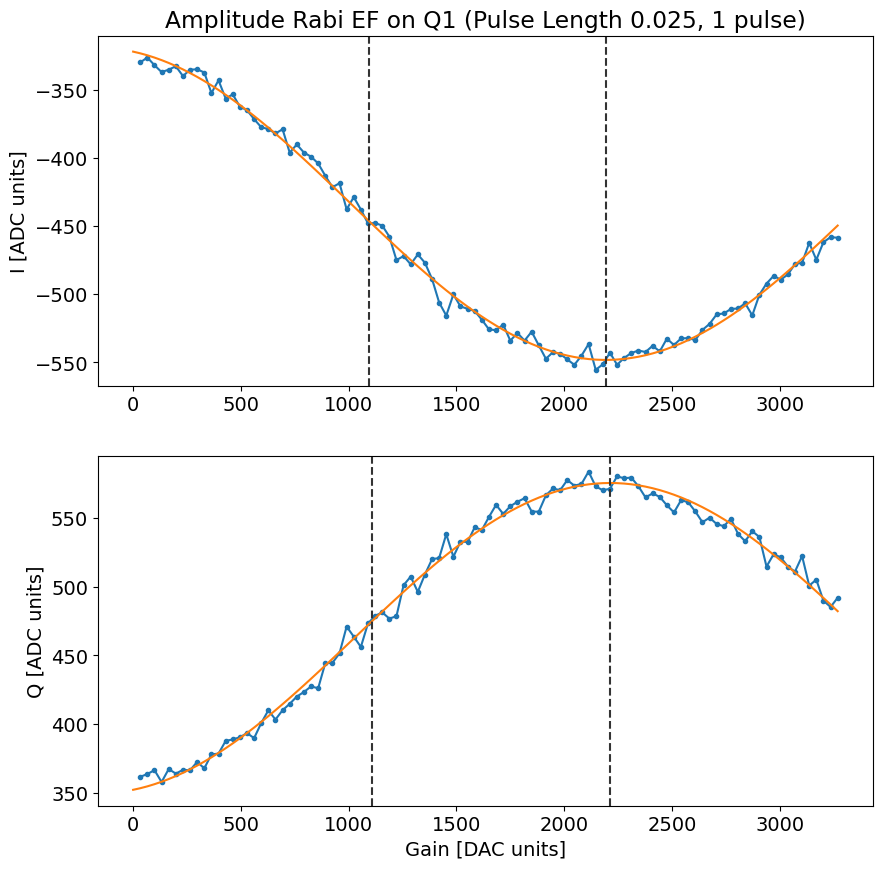

*Set EF pi pulse sigma for qubit 1 to 0.025*
*Set EF pi pulse gain for qubit 1 to 2203*
[{'T2R': 48.17842249635457, 'T2R err': 1.5564438343919038, 'Qubit freq': 4109.191979657045, 'Pi pulse len': 0.02, 'Pi pulse gain': 1958}, {'EF pi pulse len': 0.025, 'EF pi pulse gain': 2203, 'Qubit EF freq': 3318.638485737792, 'T2R EF': 1.4843867582745391, 'T2R EF err': 0.08344309151009062}, {'T2R': 42.58841611775653, 'T2R err': 4.987599156434765, 'Qubit freq': 4763.932449457171, 'Pi pulse len': 0.015, 'Pi pulse gain': 8609, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 6303, 'Qubit EF freq': 4576.568833764635, 'T2R EF': 11.928737962468755, 'T2R EF err': 1.1005834024982384}, {}]


In [68]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain*n_pulses)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [86]:
if save_data: saved_files.append(amprabiEF.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00005_amp_rabi_EF_qubit3.h5


## EF Ramsey Fringe Round 2
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [179]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [87]:
t2EFr_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr_2.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(80), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq/10, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=reps,
    rounds=rounds,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr_2.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/10 [00:00<?, ?it/s]

Current pi pulse frequency: 4207.887222461797
Fit frequency from amps [MHz]: 0.19440776713480343 +/- 0.0008596379538932287
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4207.892814694663
 	4207.492814694662
T2 Ramsey from fit amps [us]: 24.579894580412418 +/- 3.3297587176343777
Current pi pulse frequency: 4207.887222461797
Fit frequency from I [MHz]: 0.1943573210892535 +/- 0.0008671935495275817
Suggested new pi pulse frequency from fit I [MHz]:
 	4207.892865140708
 	4207.492865140708
T2 Ramsey from fit I [us]: 24.243179728293857 +/- 3.2680109892909535
Fit frequency from Q [MHz]: 0.194710397648418 +/- 0.0009222197391509685
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4207.892512064149
 	4207.492512064148
T2 Ramsey from fit Q [us]: 24.65871963678366 +/- 3.5859126691697014


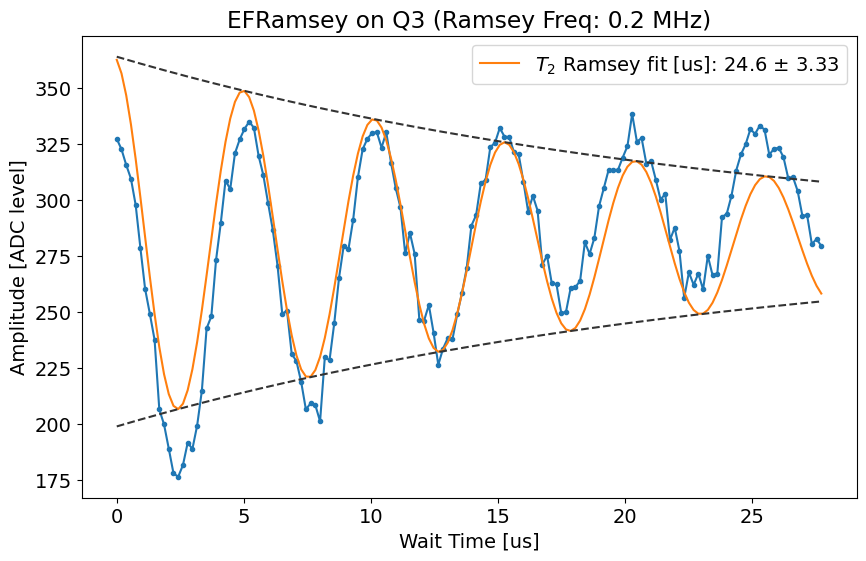

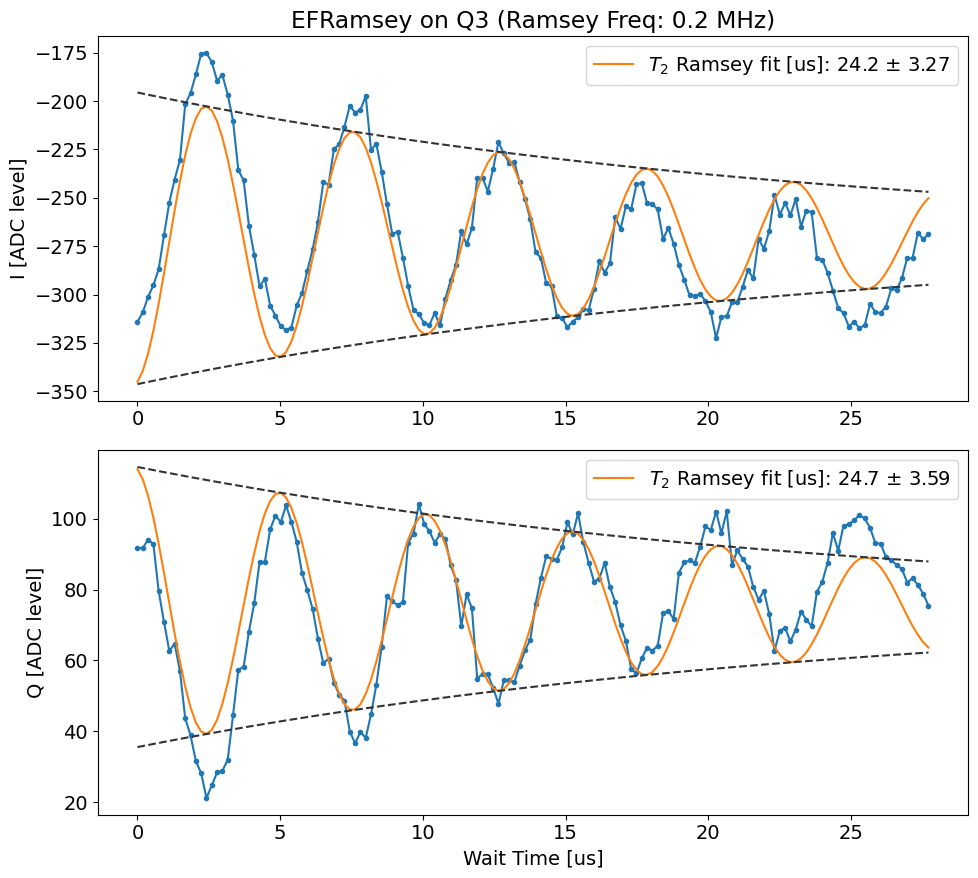

*Set qubit 3 EF freq to 4207.892814694663*
{'T2R': 45.05585862624684, 'T2R err': 1.692388940682623, 'Qubit freq': 4380.611423383357, 'Pi pulse len': 0.01, 'Pi pulse gain': 3936, 'T1': 48.26692080291215, 'T1 err': 0.9029257400818065, 'Single shot g-e fidelity (%)': 71.26534490086756, 'Qubit EF freq': 4207.892814694663, 'EF pi pulse len': 0.008, 'EF pi pulse gain': 3504, 'Qubit temp [mK]': 55.41173690436507, 'Qubit E thermal population (%)': 2.3021828354464504, 'T2R EF': 24.579894580412418, 'T2R EF err': 3.3297587176343777}


In [88]:
# # TESTING
# # t2EFr_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr_2.data = temp_data

t2EFr_2.analyze(fit=True)
t2EFr_2_fit, t2EFr_2_fit_err, t2EFr_2_adjust = meas.fitting.get_best_fit(t2EFr_2.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr_2.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_2_fit, (list, np.ndarray)):
    t2EFr_2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr_2.display(fit=True)

if t2EFr_2_adjust[0] > ramseyEF_freq/10:
    print('WARNING: your EF frequency is not converging!')
else:
    yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_2_adjust[0]
    alt_qubit_freq = old_qubit_freq + t2EFr_2_adjust[1]
    print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
    results_Qi.update({'T2R EF':t2EFr_2_fit[3], 'T2R EF err':np.sqrt(t2EFr_2_fit_err[3][3])})
    results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)

In [182]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00000_ramseyEF_qubit0.h5


## EF error amplification

In [ ]:
npulsecalibEF = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalibEF.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalibEF.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=10,
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
    test_pi_half=False,

    post_process='scale',
    singleshot_reps=15000,
)

print(npulsecalibEF.cfg)
import Pyro4.util
try:
    npulsecalibEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

From amps: adjust amplitude to (current gain) / 0.9859029473332448


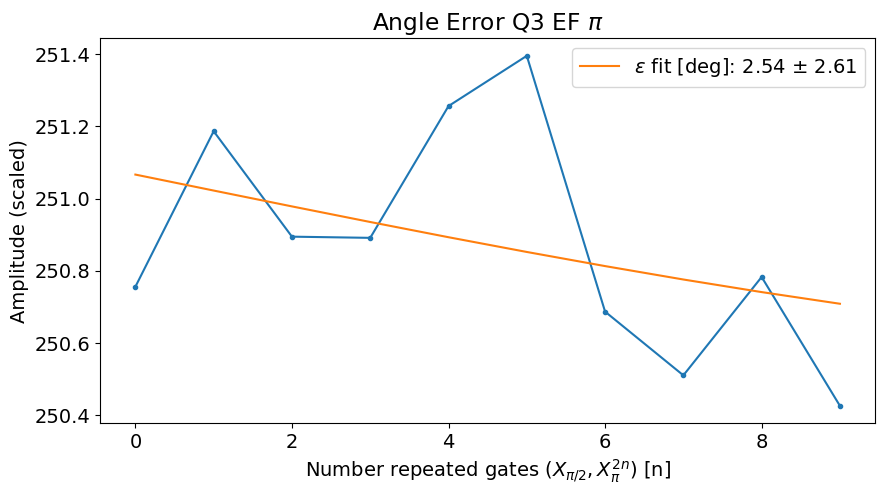

From avgi: adjust amplitude to (current gain) / 1.1015783721965873

From avgq: adjust amplitude to (current gain) / 1.000070534335844


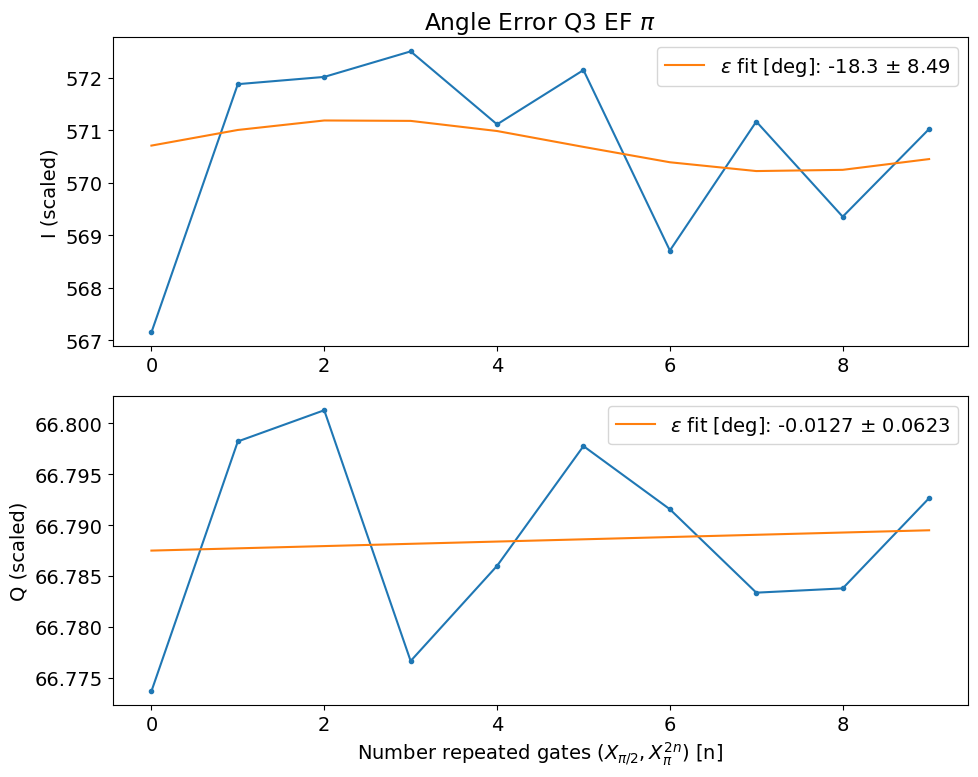

1
*Set pi pulse EF gain for qubit 3 to 3195*
{'Res freq': 6969.9822261, 'Res kappa': 0.24194125911974887, 'Qubit freq': 4381.536828838828, 'Pi pulse len': 0.01, 'Pi pulse gain': 3973, 'T1': 68.17985084293275, 'T1 err': 1.2031271496054725, 'T2R': 30.175613706054804, 'T2R err': 3.6316773617248588, 'T2E': 37.48193227526533, 'T2E err': 0.7318755515114292, 'Res chi shift (e - g)': -0.7847682119205217, 'Qubit EF freq': 4208.968431334636, 'EF pi pulse len': 0.008, 'EF pi pulse gain': 3195, 'Qubit temp [mK]': 57.99505253804845}


In [353]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalibEF.data
npulsecalibEF.analyze(fit=True, scale=data['ge_avgs'])
npulsecalibEF.display(fit=True, scale=data['ge_avgs'])

npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalibEF.data)

angle_err = npulsecalib_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ef = npulsecalibEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(round(new_amp_ef))
print(f'*Set pi pulse EF gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(results_Qi)

In [354]:
if save_data: npulsecalibEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240610\00000_NPulseExptQ3.h5


# Resonator chi shift (e/f)

In [360]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[88.34445253529802, 5000, 1000, 0, 17.90881308138134, 128.4870299118777, -3.14927028877128]
[ 8.84455942e+01  2.18252489e+03  4.26021028e+04 -1.25095649e+00
  5.31733600e+01  1.25567845e+02 -3.36161110e+00]
5925.0
950
88.44559421600414

Freq with minimum transmission: 90.76167107834438
Freq with maximum transmission: 86.05968432337748
From fit:
	f0: 6963.445594216004
	Qi: 2182.524893751444
	Qe: 42602.10281203844
	Q0: 2076.1621716330924
	kappa [MHz]: 3.353998878006054
	phi [radians]: -1.2509564861989797


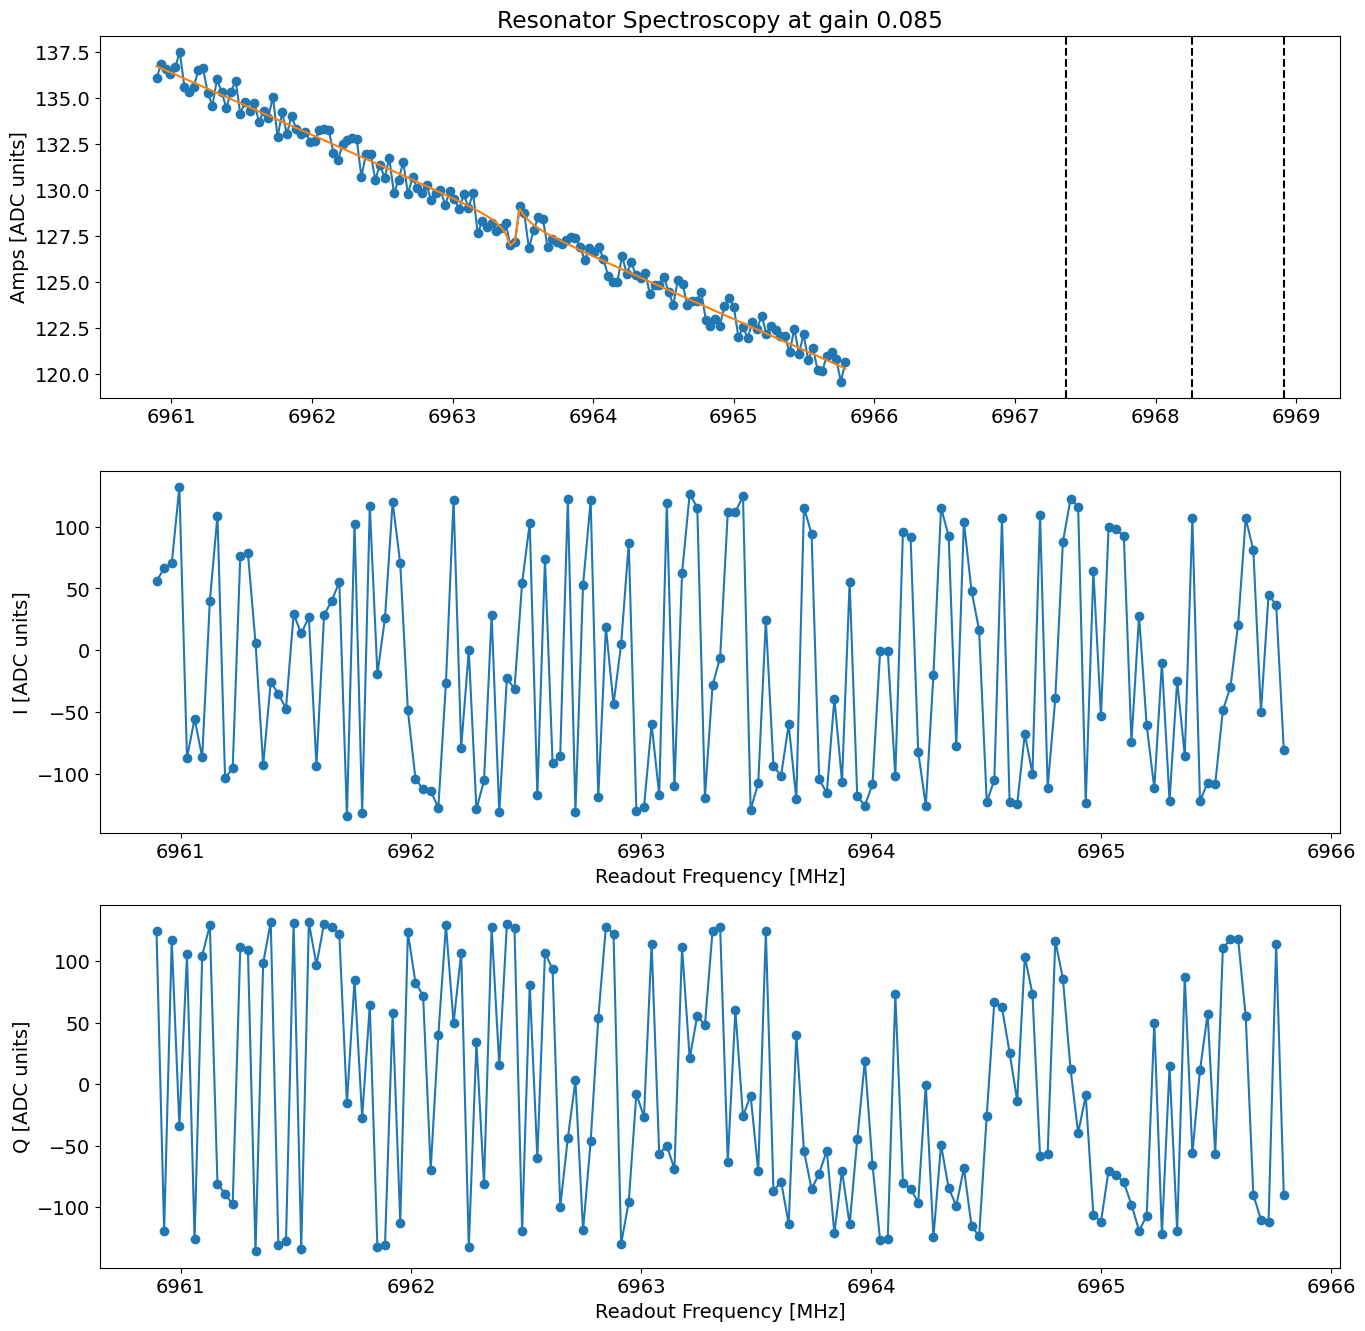

[{'Single shot g-e fidelity (%)': 41.78805960198673}, {'Qubit freq': 3450.7895590725893, 'Pi pulse len': 0.1, 'Pi pulse gain': 24945, 'T1': 88.01528902085553, 'T1 err': 2.3898312185719965, 'T2R': 44.15111045498067, 'T2R err': 1.962086656050886, 'T2E': 30.25929694612411, 'T2E err': 1.7462673977469687, 'Qubit EF freq': 3350.330233073566, 'EF pi pulse len': 0.04686378155276164, 'EF pi pulse gain': 29107, 'Qubit temp [mK]': 56.199674644449665, 'Single shot g-e fidelity (%)': 49.214973832461084}, {'Qubit freq': 4767.359704214145, 'Pi pulse len': 0.020886833661091352, 'Pi pulse gain': 2705, 'T1': 32.93056755583473, 'T1 err': 1.2325694970800454, 'T2R': 12.882410694681475, 'T2R err': 1.4701638837441797, 'T2E': 17.77399784383835, 'T2E err': 0.9103708488638977, 'Res chi shift (e - g)': 1.6390728476820868, 'Qubit EF freq': 4577.689960511519, 'EF pi pulse len': 0.022312951557475664, 'EF pi pulse gain': 1859, 'Qubit temp [mK]': 80.94855045625054, 'Single shot g-e fidelity (%)': 15.340511350378346, 

In [361]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [362]:
if save_data: saved_files.append(rspecEF_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231127\00001_resonator_spectroscopy_chi_qubit3.h5


# Single Shot

In [162]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Single shot optimization

In [23]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [361]:
qubit_i = 2

In [25]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

span_f = 1.0*abs(results_Qi['Res kappa']) # MHz
npts_f = 15
# span_f = 0
# npts_f = 1

span_gain = 0.35
npts_gain = 7
# span_gain = 0.0
# npts_gain = 8

# span_len = 5 # us
# npts_len = 10
span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2,
    start_gain=0.45,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,
    # start_gain=0.2,
    # step_gain=0,
    # expts_gain=1,

    start_len=shotopt.cfg.device.readout.readout_length[qubit_i],
    step_len=span_len/npts_len,
    expts_len=npts_len,
    # start_len=7,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.2289384210617, 5794.744, 501.2459, -230.0617739], 'gain': [0.45, 0.75, 0.95, 0.53], 'readout_length': [7.0, 12.0, 8.0, 9.0], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4113.184597434056, 3449.2891884153933, 4764.553493770534, 4382.5319372213835], 'f_ef': [3886.959357408112, 3349.489154901564, 4574.694757567985, 4209.792630242738], 'f_Q1_ZZ': [3445.1695202603087, 0, 3449.3409621315604, 3449.179169646872], 'f_Q_ZZ1': [4111.357154037054, 0, 4765.446645017305, 4379.754451085988], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5890.45, 5145.966666666667], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [53.81744103399963, 55.95274071800953, 44.5514225071792, 4.324246873301848, 2.3034231276846207, 6.286079155406997], 'ZZs': [0.0, -5.247353163402295, -0.13680586790724192, -0.5636336744364598, -5.274533978365071, 0.0, -1.086931693679162, -1.3240606637937162, -0.19332997

  0%|          | 0/15 [00:00<?, ?it/s]

freq: 5794.643999999999, gain: 0.45, len: 12.0
	fid ge [%]: 37.17162288305108
freq: 5794.643999999999, gain: 0.5, len: 12.0
	fid ge [%]: 40.22536338178424
freq: 5794.643999999999, gain: 0.55, len: 12.0
	fid ge [%]: 46.06153538451282
freq: 5794.643999999999, gain: 0.6, len: 12.0
	fid ge [%]: 46.176411760784056
freq: 5794.643999999999, gain: 0.65, len: 12.0
	fid ge [%]: 48.64828827627588
freq: 5794.643999999999, gain: 0.7, len: 12.0
	fid ge [%]: 55.13700913394226
freq: 5794.643999999999, gain: 0.75, len: 12.0
	fid ge [%]: 57.797186479098606
freq: 5794.643999999999, gain: 0.8, len: 12.0
	fid ge [%]: 59.419275260859415
freq: 5794.657333333333, gain: 0.45, len: 12.0
	fid ge [%]: 37.194573152438416
freq: 5794.657333333333, gain: 0.5, len: 12.0
	fid ge [%]: 42.62950863390893
freq: 5794.657333333333, gain: 0.55, len: 12.0
	fid ge [%]: 47.8981231456479
freq: 5794.657333333333, gain: 0.6, len: 12.0
	fid ge [%]: 50.29504917486247
freq: 5794.657333333333, gain: 0.65, len: 12.0
	fid ge [%]: 53.8000

(4, 5, 0)
[5794.644      5794.65733333 5794.67066667 5794.684      5794.69733333
 5794.71066667 5794.724      5794.73733333 5794.75066667 5794.764
 5794.77733333 5794.79066667 5794.804      5794.81733333 5794.83066667]
[0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8 ]
[12.]
Max fidelity 71.70478031868791 %
Set params: 
 angle (deg) 44.86743589733361 
 threshold 324.86623208205214 
 freq [Mhz] 5794.697333333333 
 gain [dac units] 0.7 
 readout length [us] 12.0


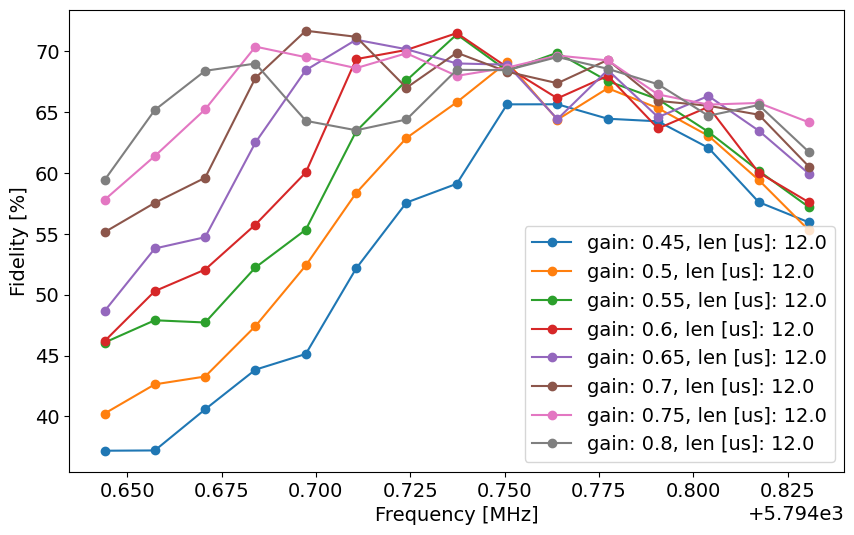

[[[0.37171623]
  [0.40225363]
  [0.46061535]
  [0.46176412]
  [0.48648288]
  [0.55137009]
  [0.57797186]
  [0.59419275]]

 [[0.37194573]
  [0.42629509]
  [0.47898123]
  [0.50295049]
  [0.538     ]
  [0.57554341]
  [0.61402047]
  [0.6518884 ]]

 [[0.40576038]
  [0.43273333]
  [0.47714924]
  [0.52068678]
  [0.54730315]
  [0.59615321]
  [0.6524    ]
  [0.68408947]]

 [[0.43837717]
  [0.4742    ]
  [0.52243483]
  [0.55768526]
  [0.62517501]
  [0.67828928]
  [0.7039568 ]
  [0.69004834]]

 [[0.45128171]
  [0.52403494]
  [0.55346667]
  [0.60053333]
  [0.68462282]
  [0.7170478 ]
  [0.69526953]
  [0.64295477]]

 [[0.52155072]
  [0.58359169]
  [0.63428781]
  [0.69368979]
  [0.70964731]
  [0.71204747]
  [0.68628954]
  [0.6352    ]]

 [[0.57575253]
  [0.62884192]
  [0.67613428]
  [0.70124675]
  [0.70182691]
  [0.67015602]
  [0.69851323]
  [0.64406667]]

 [[0.59121971]
  [0.65824388]
  [0.7140238 ]
  [0.71506667]
  [0.69013333]
  [0.69895663]
  [0.67993333]
  [0.6848895 ]]

 [[0.65651043]
  [0.6912

In [26]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

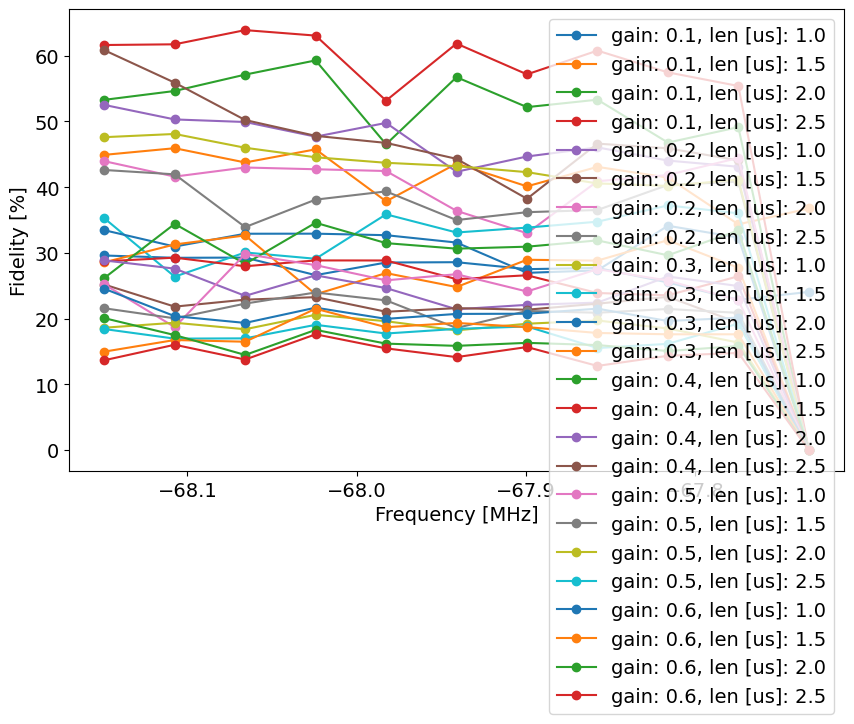

In [434]:

# Using readlines()
file1 = open('C:\\Users\\slab\\Downloads\\singleshot_opt.txt', 'r')
lines = file1.readlines()
freqs = []
gains = []
lengths = []
fids = []

line = lines[0]
words = line.split()
freq = float(words[1][:-1])
freqs.append(freq)
gain = float(words[3][:-1])
gains.append(gain)
length = float(words[5])
lengths.append(length)

fid_line = lines[1]
fids.append(float(fid_line.split()[3]))
 
# Strips the newline character
for i in range(2, len(lines), 2):
    line = lines[i]
    words = line.split()
    freq = float(words[1][:-1])
    if freq not in freqs: freqs.append(freq)
    gain = float(words[3][:-1])
    if gain not in gains: gains.append(gain)
    length = float(words[5])
    if length not in lengths: lengths.append(length)

    fid_line = lines[i+1]
    fids.append(float(fid_line.split()[3]))
    continue

fids = np.append(fids, [0]*22)
fids = np.reshape(fids, newshape=(len(freqs), len(gains), len(lengths)))

# lenpts = [data['lenpts'][0]]
for g_ind, gain in enumerate(gains):
    for l_ind, l in enumerate(lengths):
        plt.plot(freqs, fids[:,g_ind, l_ind], 'o-', label=f'gain: {gain:.2}, len [us]: {l}')
plt.xlabel('Frequency [MHz]')
plt.ylabel(f'Fidelity [%]')
plt.legend()
plt.show()


In [306]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit0.h5


next qubit

In [36]:
qubit_i = 2
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.6
npts_gain = 6

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.1,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=5,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [310]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit3.h5


next qubit

In [41]:
qubit_i = 3
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.1
npts_gain = 8

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=8.0,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [314]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit1.h5


## Best readout parameters

In [139]:
qubit_i = 2

In [163]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=20000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain[qubit_i]=gain_opt
# print(freq_opt, gain_opt)
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain[qubit_i] = 0.48
# shot.cfg.device.readout.readout_length = 9.0 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0489384211, 5794.92933333, 501.37390000000005, -229.8257739], 'gain': [0.48, 0.9, 0.95, 0.7], 'readout_length': [8.0, 16.0, 6.0, 9.0], 'relax_delay': [300, 350, 300, 350]}, 'qubit': {'f_ge': [4109.218389312247, 3452.659891436045, 4763.747684807444, 4380.611423383357], 'f_ef': [3883.3488000631655, 3318.950382626777, 4576.0799477505025, 4207.892814694663], 'f_Q1_ZZ': [3444.462481055608, 0, 3448.8560708281275, 3448.654699877598], 'f_Q_ZZ1': [4106.743203202591, 0, 4762.356910269308, 4380.156827278604], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5886.566666666667, 5147.15], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653352423196, 2.6415018214608046, 6.386231497692186], 'ZZs': [0.0, -5.538894177639122, -0.17371704848028457, -0.49154392713080597, -5.368399959515955, 0.0, -0.9748101869963648, -1.176181137525873, 

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Unrotated:
Ig -105.82099267697315 +/- 105.3390551582438 	 Qg -260.3923921887714 +/- 154.23110922846942 	 Amp g 281.07344307303555 +/- 144.04684165211017
Ie -30.54353132628153 +/- 103.36950338724746 	 Qe -682.0282750203417 +/- 166.56441094926487 	 Amp e 682.7118537370669 +/- 160.933427288748
Rotated:
Ig 240.7282913237425 +/- 105.3390551582438 	 Qg -145.13135758291537 +/- 154.23110922846942 	 Amp g 281.09290492203587 +/- 144.04684165211017
Ie 671.4182440021555 +/- 103.36950338724746 	 Qe -126.4033646243553 +/- 166.56441094926487 	 Amp e 683.2131943744176 +/- 160.933427288748
g correctly categorized: 90.29951497574878%
e correctly categorized: 87.974398719936%


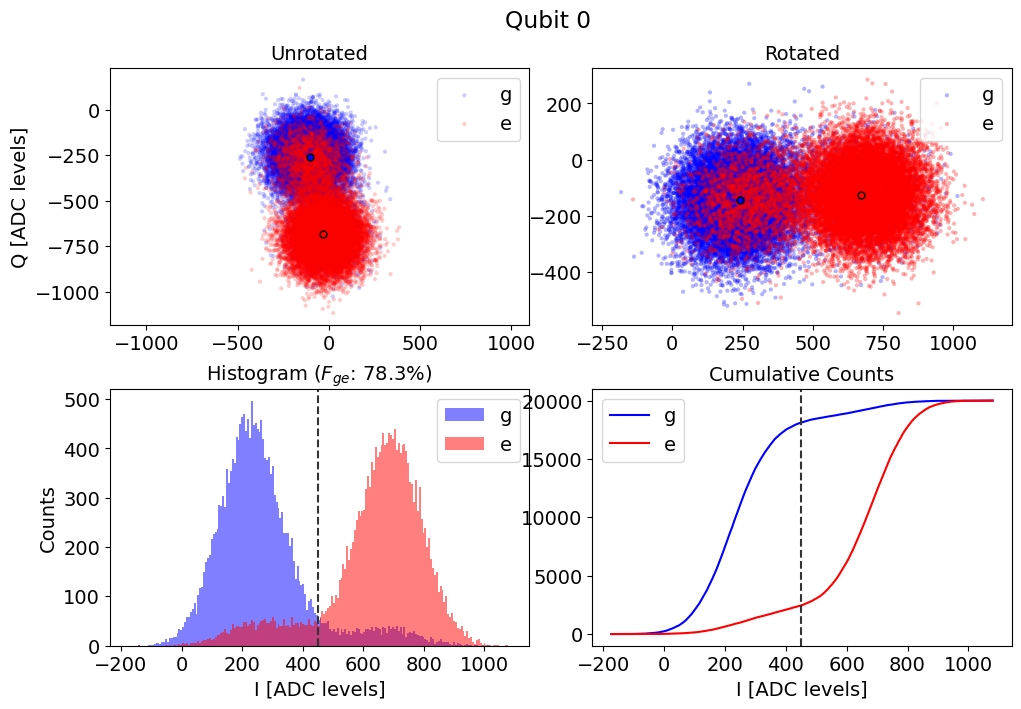

ge fidelity (%): 78.33891694584729
rotation angle (deg): 81.54392567429251
threshold ge: 449.77152206981737


In [164]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)
results_Qi.update({'Single shot g-e fidelity (%)': 100*shot.data['fids'][0]})

In [422]:
if save_data: saved_files.append(shot.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00000_single_shot_qubit3.h5


# Results

In [165]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-391.0489384211, 5794.92933333, 501.37390000000005, -229.8257739], 'gain': [0.48, 0.9, 0.95, 0.7], 'readout_length': [8.0, 16.0, 6.0, 9.0], 'relax_delay': [300, 350, 300, 350]}, 'qubit': {'f_ge': [4109.218389312247, 3452.659891436045, 4763.747684807444, 4380.611423383357], 'f_ef': [3883.3488000631655, 3318.950382626777, 4576.0799477505025, 4207.892814694663], 'f_Q1_ZZ': [3444.462481055608, 0, 3448.8560708281275, 3448.654699877598], 'f_Q_ZZ1': [4106.743203202591, 0, 4762.356910269308, 4380.156827278604], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5886.566666666667, 5147.15], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653352423196, 2.6415018214608046, 6.386231497692186], 'ZZs': [0.0, -5.538894177639122, -0.17371704848028457, -0.49154392713080597, -5.368399959515955, 0.0, -0.9748101869963648, -1.176181137525873, 